FASE 0: PREPARACIÓN

El sistema requiere de array, ast, glob, numpy, pandas, re (para descomponer los abstracts), shutil (para desempaquetar GloVe), scikit-learn (sklearn) y keras (tensorflow), además de sys para saber el sistema operativo

Comentado se encuentra una posible opción para tratar que tensorflow no utilize la GPU

In [1]:
import os
# Sin GPU
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from array import array
import ast
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from shutil import unpack_archive
import sklearn.model_selection
from sys import platform
import tensorflow as tf

#try:
#    import tensorflow_addons as tfa
#except ImportError:
#    from tensorflow_addons import metrics

from keras.models import load_model

import datetime

%load_ext tensorboard



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


Primero cargamos el conjunto de entrenamiento y test, en este caso de un .csv mediante pandas. Utilizamos una función de pandas para que se muestre todo.

Más tarde los dividimos en esos subconjuntos y lo comprobamos

In [2]:
pd.set_option('display.max_rows', None) # Se muestra todo
pd.set_option('display.max_columns', None) # Se muestra todo
x_dataframe = pd.read_csv('papers.csv') #tf.keras.datasets.mnist.load_data()

In [3]:
x_test, x_train = sklearn.model_selection.train_test_split(x_dataframe, test_size=0.9, train_size=0.1, random_state=None, shuffle=True, stratify=None)
# validación en el propio fit, validation_split = 0.1

print(f'Total shape: {str(x_dataframe.shape)} input {x_dataframe.keywords.shape} output') 
print(f'Training shape: {str(x_train.shape)} input {x_train.keywords.shape} output') # Estructura: 60k números de 28x28 
print(f'Test shape: {str(x_test.shape)} input {x_test.keywords.shape} output')

Total shape: (448, 8) input (448,) output
Training shape: (404, 8) input (404,) output
Test shape: (44, 8) input (44,) output


Aquí es conveniente definir una función que a partir de un conjunto, pueda devolvernos las cadenas de título, abstract y palabras clave debidamente separadas en sus palabras. De esta forma se pueden sacar las palabras del conjunto de entrenamiento, test y cualquier conjunto futuro.

Tras realizar la extracción de palabras de una forma más eficiente con GloVe, solo nos hemos quedado con la parte que separaba las keywords, el resto de secciones se han comentado.

In [3]:
def extraerPalabrasDelConjunto (x_train, listaPalabras):
#    listaTitlesTemp = x_train.title.tolist() # Listarlos
#    listaTitlesPorArticulo = [] # Con esto sabemos cuales son de cada artículo
#    listaTitles = [] # Con esto los pasamos a una lista de 1 nivel
  
#    listaAbstractsTemp = x_train.abstract.tolist() # Listarlos
#    listaAbstractsPorArticulo = [] # Con esto sabemos cuales son de cada artículo
#    listaAbstracts = [] # Con esto los pasamos a una lista de 1 nivel

    listaKeywordsTemp = x_train.keywords.tolist() # Listarlos
    listaKeywordsPorArticulo = [] # Con esto sabemos cuales son de cada artículo
    listaKeywords = [] # Con esto los pasamos a una lista de 1 nivel    

    for valor in listaKeywordsTemp:
        #chunks = valor.split(',')
        chunks = re.split(',[ ]*',valor) # Son separados por comas, pero ignoramos los espacios antes de dichos tags
        listaKeywordsPorArticulo.append(chunks)
        for chunk in chunks:
            listaKeywords.append(chunk)
            listaPalabras.append(chunk)
        
#    for valor in listaAbstractsTemp:
#        chunks = re.split('[^a-zA-Z0-9]+',valor) # separo dejando solo caracteres normales
#        listaAbstractsPorArticulo.append(chunks)
#        for chunk in chunks:
#            listaAbstracts.append(chunk)
#            listaPalabras.append(chunk)
        
#    for valor in listaTitlesTemp:
#        chunks = re.split('[^a-zA-Z0-9]+',valor)
#        listaTitlesPorArticulo.append(chunks)
#        for chunk in chunks:
#            listaTitles.append(chunk)
#            listaPalabras.append(chunk)
            
#    return listaTitlesPorArticulo, listaTitles, listaAbstractsPorArticulo, listaAbstracts, listaKeywordsPorArticulo, listaKeywords, listaPalabras
    return listaKeywordsPorArticulo, listaKeywords

In [5]:
# Verifico que me sale lo mismo
listaPalabrasTotal = []
#listaTitlesTotalPorArticulo, listaTotalTitles, listaTotalAbstractsPorArticulo, listaTotalAbstracts, listaTotalKeywordsPorArticulo, listaTotalKeywords, listaPalabrasTotal = extraerPalabrasDelConjunto (x_dataframe, listaPalabrasTotal)
#print(len(listaPalabrasTotal))

#listaPalabrasTrain = []
#listaTitlesPorArticulo, listaTitles, listaAbstractsPorArticulo, listaAbstracts, listaKeywordsPorArticulo, listaKeywords, listaPalabrasEntrena = extraerPalabrasDelConjunto (x_train, listaPalabrasTrain)
#print(len(listaPalabrasEntrena))
listaPalabrasTest = []
#listaTestTitlesPorArticulo, listaTestTitles, listaTestAbstractsPorArticulo, listaTestAbstracts, listaTestKeywordsPorArticulo, listaTestKeywords, listaPalabrasTest = extraerPalabrasDelConjunto (x_test, listaPalabrasTest)
#print(len(listaPalabrasTest))
listaTotalKeywordsPorArticulo, listaTotalKeywords = extraerPalabrasDelConjunto (x_dataframe, listaPalabrasTotal)
listaTestKeywordsPorArticulo, listaTestKeywords = extraerPalabrasDelConjunto (x_test, listaPalabrasTest)
print(len(listaTotalKeywordsPorArticulo))
print(len(listaTotalKeywords))
print(len(listaTestKeywordsPorArticulo))
print(len(listaTestKeywords))

448
2126
44
221


Es ahora cuando generamos una traducción de palabras obtenidas a valores que una red neuronal pueda entender, es decir, números.

El primer paso consiste en ordenar y quitarnos de en medio términos repetidos. Es posible que el utilizar mayúsculas en vez de minúsculas sea un diferenciador importante, por lo que términos con mismas letras pero capitalizados de forma diferente tengan un matiz de significado interesante.

(esa sección se ha comentado como se indicó anteriormente)

También resulta interesante hacer lo mismo para las keywords obtenidas, así sabemos las dimensiones de salida más tarde.

In [6]:
# Ordenamos el número de palabras totales
#seenGenerico = list(set(listaPalabrasTotal))
#seenGenerico.sort()
#otroTes = sorted(seenGenerico, key=str.lower)
#print(len(otroTes))
#print(otroTes)

9727
['', '0', '000', '0003', '01', '04', '05', '06', '09', '1', '10', '100', '1000', '100s', '101', '104', '106', '108', '109', '11', '116', '12', '120', '123', '13', '130', '14', '15', '153600', '16', '160', '1635', '17', '178', '18', '1833', '1874', '19', '1915', '1H', '2', '2-dim distance measure', '20', '2004', '2006', '2007', '2009', '2010', '2011', '2012', '2013', '2015', '2016', '2017', '2099', '21', '211', '216', '22', '23', '24', '243', '25', '250', '2586', '26', '27', '28', '29', '2D', '2d:4d', '2v1', '2v2', '3', '30', '31', '31m', '33', '34', '35', '3521', '36', '37', '39', '3960', '3D', '3d', '3d shapes', '3d-convnets', '3MW', '4', '40', '41', '410', '412', '42', '43', '44160', '47', '49', '4D', '4th', '5', '50', '500', '5000', '53', '54', '55', '56', '563', '59', '6', '60', '61', '63', '65', '67', '68', '7', '70', '72', '74', '75', '76', '77', '78', '79', '8', '80', '800', '81', '82', '83', '85', '86', '87', '88', '89', '9', '90', '901', '91', '92', '93', '94', '95', '97'

In [26]:
seenKeywords = list(set(listaTotalKeywords))
keywordsOrigin = sorted(seenKeywords, key=str.lower)
print(len(keywordsOrigin))
print(keywordsOrigin)

NameError: name 'listaTotalKeywords' is not defined

Ahora este resultado se debe guardar para un uso posterior. No debemos ejecutar las líneas de arriba de nuevo a menos que debamos corregir algo.

Tras leer del fichero, debemos crear el diccionario y un array adecuado para definir dichas palabras como números. Tambiñen es útil sacar los keywords para hacer lo mismo y optimizar el resultado de salida.

In [13]:
#f = open("palabrasEntrada.txt", "w")
#f.write(str(otroTes))
#f.close()

In [52]:
f = open("keywordsIniciales.txt", "w")
f.write(str(keywordsOrigin))
f.close()

In [7]:
# FASE 1: Los de arriba ya no se vuelven a ejecutar, reabrimos y pasamos a lista
try:
    f = open("palabrasEntrada.txt", "r")
    cadenaMensaje = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaMensaje = "ERROR"
finally:  
    res = ast.literal_eval(cadenaMensaje)
    print(len(res))
    f.close()

9727


In [8]:
try:
    f = open("keywordsIniciales.txt", "r")
    cadenaRetornoKeywords = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaRetornoKeywords = "[]"
finally:  
    misKeywordsRetornadas = ast.literal_eval(cadenaRetornoKeywords)
    print(len(misKeywordsRetornadas))
    f.close()

1534


In [9]:
# * FASE 1.1 Creamos el diccionario (no se olvide NO lo hemos comentado porque seguimos usándolo para una variable posterior)
diccionarioLengua = dict()

diccionarioLengua["<UNU>"] = 0 # Establecemos el primero como valor vacio
diccionarioLengua["EsteValorEstaMuyDesconocido"] = 1 # Establecemos el segundo como valor desconocido
for i in range(0, len(res)):
    diccionarioLengua[res[i]] = i+2

    
print(diccionarioLengua)
print(len(diccionarioLengua))

{'<UNU>': 0, 'EsteValorEstaMuyDesconocido': 1, '': 2, '0': 3, '000': 4, '0003': 5, '01': 6, '04': 7, '05': 8, '06': 9, '09': 10, '1': 11, '10': 12, '100': 13, '1000': 14, '100s': 15, '101': 16, '104': 17, '106': 18, '108': 19, '109': 20, '11': 21, '116': 22, '12': 23, '120': 24, '123': 25, '13': 26, '130': 27, '14': 28, '15': 29, '153600': 30, '16': 31, '160': 32, '1635': 33, '17': 34, '178': 35, '18': 36, '1833': 37, '1874': 38, '19': 39, '1915': 40, '1H': 41, '2': 42, '2-dim distance measure': 43, '20': 44, '2004': 45, '2006': 46, '2007': 47, '2009': 48, '2010': 49, '2011': 50, '2012': 51, '2013': 52, '2015': 53, '2016': 54, '2017': 55, '2099': 56, '21': 57, '211': 58, '216': 59, '22': 60, '23': 61, '24': 62, '243': 63, '25': 64, '250': 65, '2586': 66, '26': 67, '27': 68, '28': 69, '29': 70, '2D': 71, '2d:4d': 72, '2v1': 73, '2v2': 74, '3': 75, '30': 76, '31': 77, '31m': 78, '33': 79, '34': 80, '35': 81, '3521': 82, '36': 83, '37': 84, '39': 85, '3960': 86, '3D': 87, '3d': 88, '3d sh

In [10]:
# * FASE 1.1 Creamos el diccionario de keywords
diccionarioKeywords = dict()
diccionarioKeywords["EsteValorEstaMuyDesconocido"] = 0 # Establecemos el primero como valor desconocido
for i in range(0, len(misKeywordsRetornadas)):
    diccionarioKeywords[misKeywordsRetornadas[i]] = i+1

print(diccionarioKeywords)
print(len(diccionarioKeywords))

{'EsteValorEstaMuyDesconocido': 0, '2-dim distance measure': 1, '2d:4d': 2, '3d shapes': 3, '3d-convnets': 4, 'abnormal event detection': 5, 'academic success': 6, 'accelerometer': 7, 'accelerometer data': 8, 'accelerometers': 9, 'accreditation and assesments': 10, 'accuracy': 11, 'achievements information': 12, 'acoustic feature learning': 13, 'action bank features': 14, 'activation function': 15, 'active contour method': 16, 'active learning': 17, 'active set shrinking': 18, 'activity detection': 19, 'activity forecasting': 20, 'activity recognition': 21, 'adaptation method': 22, 'adaptation models': 23, 'adaptive approaches': 24, 'adaptive learning': 25, 'adaptive scheduling': 26, 'adaptive threshold': 27, 'adenoviral conjunctivitis (pink eye)': 28, 'adversarial machine learning': 29, 'afis': 30, 'age': 31, 'aggregated netflows': 32, 'aggression': 33, 'agriculture': 34, 'air combat': 35, 'algorithm': 36, 'algorithm design and analysis': 37, 'algorithm recognition': 38, 'algorithm se

In [11]:
diccionarioKeywordsInvert = {index: word for word, index in diccionarioKeywords.items()}
print(diccionarioKeywordsInvert)
print(len(diccionarioKeywordsInvert))

{0: 'EsteValorEstaMuyDesconocido', 1: '2-dim distance measure', 2: '2d:4d', 3: '3d shapes', 4: '3d-convnets', 5: 'abnormal event detection', 6: 'academic success', 7: 'accelerometer', 8: 'accelerometer data', 9: 'accelerometers', 10: 'accreditation and assesments', 11: 'accuracy', 12: 'achievements information', 13: 'acoustic feature learning', 14: 'action bank features', 15: 'activation function', 16: 'active contour method', 17: 'active learning', 18: 'active set shrinking', 19: 'activity detection', 20: 'activity forecasting', 21: 'activity recognition', 22: 'adaptation method', 23: 'adaptation models', 24: 'adaptive approaches', 25: 'adaptive learning', 26: 'adaptive scheduling', 27: 'adaptive threshold', 28: 'adenoviral conjunctivitis (pink eye)', 29: 'adversarial machine learning', 30: 'afis', 31: 'age', 32: 'aggregated netflows', 33: 'aggression', 34: 'agriculture', 35: 'air combat', 36: 'algorithm', 37: 'algorithm design and analysis', 38: 'algorithm recognition', 39: 'algorith

In [11]:
# * FASE 1.2 Lo pasamos a Array, e incluimos el valor vacío. Esto usaba codificación one-hot
#matrizDiccionarioEntrada = array("i", diccionarioLengua.values())
    
#vocabulary_train = tf.keras.utils.to_categorical(matrizDiccionarioEntrada, num_classes=len(matrizDiccionarioEntrada), dtype='int')
#print(vocabulary_train)

#matrizDiccionarioVacio = np.array([0] * len(vocabulary_train[diccionarioLengua["EsteValorEstaMuyDesconocido"]])) # Valor vacío 
#print(matrizDiccionarioVacio)

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[0 0 0 ... 0 0 0]


In [12]:
# * FASE 1.2.2 Pasamos las keywords a Array, e incluimos el valor vacío
matrizKeywordsEnLaSalida = array("i", diccionarioKeywords.values())
    
keywords_train = tf.keras.utils.to_categorical(matrizKeywordsEnLaSalida, num_classes=len(matrizKeywordsEnLaSalida), dtype='int')
print(keywords_train)

matrizSalidaSinKeywords = np.array([0] * len(keywords_train[diccionarioKeywords["EsteValorEstaMuyDesconocido"]])) # Valor vacío 
print(matrizSalidaSinKeywords)
print(len(matrizSalidaSinKeywords))

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[0 0 0 ... 0 0 0]
1535


FASE 1.3 Ahora tomamos el texto y pasamos su abstract, title y keywords al número del diccionario adecuado. Esto nos permitirá tener la entrada y salida esperadas. Muy recomendable que se ajusten las entradas  para tener la misma longitud.

In [31]:
#LA FUNCIÓN DE ABAJO HA SIDO COMENTADA POR HABER SIDO REEMPLAZADA POR OTRO MÉTODO MEJOR

#def textoaDiccionario(listadeTitulos, listaDeAbstractos, listaDeClaves, numPalabrasEntrada):
#    entradaEntendiblePorLaRed = []
#    salidaEntendiblePorLaRed = []
#    salidaEntendiblePorLaRedOptimizada = []
#    entradaIndicesTotal = np.zeros((len(listaDeAbstractos), numPalabrasEntrada))
#    #entradaIndicesTotal = []
#    contados = 0
#
#    for i, title, abstract, keywords in zip(range(len(listadeTitulos)), listadeTitulos, listaDeAbstractos, listaDeClaves):
#        print("CONTENIDO ARTÍCULO")
#        # ENTRADA
#        unTitleAbstract = []
#        keywordsArticulo = []
#        entradaIndices = []
#        contj = 0 
#        print(i)
#        print(contados)
#        print(f'Longitud a leer: {len(title)+len(abstract)}')
#        for palabra in title:
#            #print(palabra)
#            elIndice = diccionarioLengua[palabra]
#            if elIndice is None:
#                elIndice = diccionarioLengua["EsteValorEstaMuyDesconocido"]
#            unTitleAbstract.append(vocabulary_train[elIndice])
#            entradaIndicesTotal[i][contj] = elIndice
#            contj = contj + 1
#        for palabra in abstract:
#            elIndice = diccionarioLengua[palabra]
#            if elIndice is None:
#                elIndice = diccionarioLengua["EsteValorEstaMuyDesconocido"]
#            unTitleAbstract.append(vocabulary_train[elIndice])
#            entradaIndicesTotal[i][contj] = elIndice
#            contj = contj + 1
#        # Relleno con el padding adecuado 
#
#        for long in range(len(unTitleAbstract)-1, numPalabrasEntrada-1):
#            unTitleAbstract.append(matrizDiccionarioVacio)
#        
#        # SALIDA ESPERADA
#        auxiliar = matrizDiccionarioVacio.copy()
#        auxiliarCompressed = matrizSalidaSinKeywords.copy()
#        for palabra in keywords:
#            auxiliar[diccionarioLengua[palabra]] = 1
#            auxiliarCompressed[diccionarioKeywords[palabra]] = 1
#        
#        entradaEntendiblePorLaRed.append(unTitleAbstract)
#        salidaEntendiblePorLaRed.append(auxiliar)
#        salidaEntendiblePorLaRedOptimizada.append(auxiliarCompressed)
#        
#        contados = contados + 1
#        
#        
#    return entradaEntendiblePorLaRed, np.array(entradaIndicesTotal), salidaEntendiblePorLaRed, salidaEntendiblePorLaRedOptimizada

def salidaCodificacion(listaDeClaves):
    salidaEntendiblePorLaRedOptimizada = []

    for keywords in listaDeClaves:
        keywordsArticulo = []
        entradaIndices = []
        
        # SALIDA ESPERADA
        auxiliarCompressed = matrizSalidaSinKeywords.copy()
        for palabra in keywords:
            auxiliarCompressed[diccionarioKeywords[palabra.lower()]] = 1

        salidaEntendiblePorLaRedOptimizada.append(auxiliarCompressed)     
        
    return salidaEntendiblePorLaRedOptimizada

Ahora obtenemos la entrada de cada artículo con su respectiva salida esperada.

Lo de salida compressed es meramente una variante en la que nos quitamos muchas neuronas de salida de en medio, ya que queremos solo clasificar la salida esperada entre una de dichas keywords, no de todo el espacio.

In [14]:
# Cuántas dimensiones tienen nuestros word vectors (50, 100, 200 o 300)
# Tamaño de salida del embedding
EMBEDDING_DIM = 200
# El tamaño máximo de nuestro vocabulario (se escogerán las más frecuentes)
WORDS_IN_VOCAB = len(diccionarioLengua)
# El tamaño de la frase más larga con la que alimentar el modelo
MAX_SEQUENCE_LENGTH = 333

In [15]:
#entradaEntrenamiento, entradaEntrenamientoIndices, salidaEsperada, salidaEsperadaCompressed = textoaDiccionario(listaTitlesTotalPorArticulo, listaTotalAbstractsPorArticulo, listaTotalKeywordsPorArticulo, MAX_SEQUENCE_LENGTH)
salidaEsperadaCompressed = salidaCodificacion(listaTotalKeywordsPorArticulo)
print(len(salidaEsperadaCompressed))
print("Y ahora el cjto de validacion")
#entradaTest, entradaTestIndices, salidaEsperadaTest, salidaEsperadaCompressedTest  = textoaDiccionario(listaTestTitlesPorArticulo, listaTestAbstractsPorArticulo, listaTestKeywordsPorArticulo, MAX_SEQUENCE_LENGTH)
salidaEsperadaCompressedTest = salidaCodificacion(listaTestKeywordsPorArticulo)
#print("Indices Entrada Entrenamiento")
#print(entradaEntrenamientoIndices)
#print(type(entradaEntrenamientoIndices))
#print(len(entradaEntrenamientoIndices))
#print(len(entradaEntrenamiento))
#print(len(listaTitlesTotalPorArticulo))
print(len(salidaEsperadaCompressedTest))


448
Y ahora el cjto de validacion
44


Ahora, podríamos entrenar un embedding, pero es mejor tener el de GloVe que nos lo da entrenado por nosotros y por lo tanto necesitará de menos tiempo. Cabe mencionar que esto puede tener el inconveniente de que GloVe no tenga la palabra.

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(diccionarioLengua),
    output_dim=EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
)

In [16]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'
GLOVE_DIR = 'tmp/'

if not os.path.isdir(GLOVE_DIR):
    os.makedirs(GLOVE_DIR)

# Descargamos el dataset comprimido de GloVe (si no lo tenemos ya)
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Lo descomprimimos en el directorio 'glove'
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, GLOVE_DIR)
print('OK')

Unpacking ...OK


Tomaremos el embedding de la dimensión seleccionada

In [17]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt'), "r", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word2vec[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 200-d embedding... done (400000 word vectors loaded)


In [18]:
salidaEsperadaCompressedAjustada = np.array(salidaEsperadaCompressed)
print(salidaEsperadaCompressedAjustada[0])
print(max(salidaEsperadaCompressedAjustada[0]))
salidaEsperadaCompressedAjustadaTest = np.array(salidaEsperadaCompressedTest)
print(salidaEsperadaCompressedAjustadaTest[0])

[0 0 0 ... 0 0 0]
1
[0 0 0 ... 0 0 0]


In [20]:
#entradaEntrenadaAjustada = np.array(entradaEntrenamiento)
#print(entradaEntrenadaAjustada[0])
#entradaTestAjustada = np.array(entradaTest)
#print(entradaTestAjustada[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


FASE 2: RRNN DE CONVOLUCIÓN

ENTRADA: matriz de 333 palabras, cada una con un vector identificativo.

SALIDA: capa de longitud igual al número de palabras clave que estamos buscando.

IMPORTANTE: MANTENER ORDEN

In [19]:
# TO-DO Esto es otra forma alternativa de pasar el texto a palabras
df = pd.read_csv('papers.csv')

titulosEficientes = df.title.fillna('DUMMY_VALUE').values
abstractsEficientes = df.abstract.fillna('DUMMY_VALUE').values

sentences = [ (title +". "+ abstract) for title, abstract in zip(titulosEficientes, abstractsEficientes)]

print(len(sentences))
sentences = list(sentences)
print(len(sentences))
print(sentences)

448
448
['Ensemble Statistical and Heuristic Models for Unsupervised Word Alignment. Statistical word alignment models need large amount of training data while they are weak in small-size corpora. This paper proposes a new approach of unsupervised hybrid word alignment technique using ensemble learning method. This algorithm uses three base alignment models in several rounds to generate alignments. The ensemble algorithm uses a weighed scheme for resampling training data and a voting score to consider aggregated alignments. The underlying alignment algorithms used in this study include IBM Model 1, 2 and a heuristic method based on Dice measurement. Our experimental results show that by this approach, the alignment error rate could be improved by at least %15 for the base alignment models.', 'Improving Spectral Learning by Using Multiple Representations. Spectral learning algorithms learn an unknown function by learning a spectral (e.g., Fourier) representation of the function. However

In [244]:
f = open("palabrasEntradaV2.txt", "w", encoding='utf-8')
f.write(str(sentences))
f.close()

In [20]:
# FASE 1: Los dos de arriba ya no se vuelven a ejecutar, reabrimos y pasamos a lista
try:
    f = open("palabrasEntradaV2.txt", "r")
    cadenaMensajeV2 = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaMensajeV2 = "ERROR"
finally:  
    res2 = ast.literal_eval(cadenaMensajeV2)
    print(len(res2))
    f.close()

448


In [21]:
tokenizer =   tf.keras.preprocessing.text.Tokenizer(num_words=WORDS_IN_VOCAB)
tokenizer.fit_on_texts(res2)
sequences =   tokenizer.texts_to_sequences(res2)
word_index =  tokenizer.word_index
index_word = {index: word for word, index in word_index.items()}

vocabularioz_size = len(word_index) + 1

print(f'Biggest index: {max(max(seq) for seq in sequences if len(seq) > 0)}')
print(f'Unique tokens: {len(word_index)}')

print('-' * 20)
print(type(res2))
print(f'Example comment: {res2[9]}: {sequences[9]}')
print(word_index)

Biggest index: 6756
Unique tokens: 6756
--------------------
<class 'list'>
Example comment: Detection of abnormal human behavior using a matrix approximation-based approach. Automatic detection of abnormal events is one of central tasks in video surveillance. In this paper we present a matrix approximation-based method to detect abnormal human behavior. In our model, a behavior pattern is represented by a motion matrix obtained through object tracking. We model typical motions associated with normal behaviors with a set of motion subspaces, computed through low-rank matrix approximation. Then, abnormal human behaviors are identified by the motion deviations from the representative subspaces. Our method does not require a complicated classification procedure, and can fast detect abnormal events in complex scenes. In addition, through the adaptive learning module, our model is built on the observed data, and can be expanded by incorporating new behavior patterns during the detection pro

In [22]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    value=0,
    maxlen=MAX_SEQUENCE_LENGTH
)
print(f'Data tensor shape: {data.shape}')
data[9]

Data tensor shape: (448, 333)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [23]:
print('Loading embedding with GloVe vectors... ', end='')
# Cargamos sólo las palabras elegidas de nuestro conjunto de datos
num_words = min(WORDS_IN_VOCAB, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < WORDS_IN_VOCAB:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Creamos la capa de embedding
embedding_layer = tf.keras.layers.Embedding(
  input_dim=num_words,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False,
)
print('done')

Loading embedding with GloVe vectors... done


Creamos checkpoints para guardar la versión que tenga el menor error

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn-Algigantix/model-{loss:.4f}.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

In [125]:
# Ya que tf no lo tiene y tf-addons nos falla, lo defimos por nuestra cuenta, no nos olvidemos de luego ponerlo en el load
#def f1_score(y_testI, ŷ_testI):
#    from keras import backend as K
#    # Count positive samples.
#    
#    #y_test = y_testI.astype(int)[:,0]
#    #ŷ_test = ŷ_testI.astype(int)[:,0]
#    #TP = np.sum((ŷ_test == 1) & (y_test == 1))
#    #FN = np.sum((ŷ_test == 0) & (y_test == 1))
#    #FP = np.sum((ŷ_test == 1) & (y_test == 0))
#    
#    TP = K.sum((ŷ_test == 1) & (y_test == 1))
#    FN = K.sum((ŷ_test == 0) & (y_test == 1))
#    FP = K.sum((ŷ_test == 1) & (y_test == 0))
#    #TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#    #c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
#    #c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
#
#    # If there are no true samples, fix the F1 score at 0.
#    if TP == 0:
#        return 0
#
#    # How many selected items are relevant?
#    precision = TP / (TP + FP)
#
#    # How many relevant items are selected?
#    recall = TP / (TP + FN)
#
#    # Calculate f1_score
#    f1_score = 2 * precision * recall / (precision + recall)
#    return f1_score 

In [37]:
from keras import backend as K
import tensorflow_addons # a veces me causa error, no se por que

Por favor, nótese que si ya se ha introducido una clase (o si tensoflow_Addons te funciona), la línea de abajo saltará como error (abajo, resultado de introducir la misma clase dos veces al presionar enter dos veces)

In [33]:
from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typing import Optional
class FBetaScore(tf.keras.metrics.Metric):
    r"""Computes F-Beta score.

    It is the weighted harmonic mean of precision
    and recall. Output range is `[0, 1]`. Works for
    both multi-class and multi-label classification.

    $$
    F_{\beta} = (1 + \beta^2) * \frac{\textrm{precision} * \textrm{recall}}{(\beta^2 \cdot \textrm{precision}) + \textrm{recall}}
    $$

    Args:
        num_classes: Number of unique classes in the dataset.
        average: Type of averaging to be performed on data.
            Acceptable values are `None`, `micro`, `macro` and
            `weighted`. Default value is None.
        beta: Determines the weight of precision and recall
            in harmonic mean. Determines the weight given to the
            precision and recall. Default value is 1.
        threshold: Elements of `y_pred` greater than threshold are
            converted to be 1, and the rest 0. If threshold is
            None, the argmax is converted to 1, and the rest 0.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.

    Returns:
        F-Beta Score: float.

    Raises:
        ValueError: If the `average` has values other than
        `[None, 'micro', 'macro', 'weighted']`.

        ValueError: If the `beta` value is less than or equal
        to 0.

    `average` parameter behavior:

        None: Scores for each class are returned.

        micro: True positivies, false positives and
            false negatives are computed globally.

        macro: True positivies, false positives and
            false negatives are computed for each class
            and their unweighted mean is returned.

        weighted: Metrics are computed for each class
            and returns the mean weighted by the
            number of true instances in each class.

    Usage:

    >>> metric = tfa.metrics.FBetaScore(num_classes=3, beta=2.0, threshold=0.5)
    >>> y_true = np.array([[1, 1, 1],
    ...                    [1, 0, 0],
    ...                    [1, 1, 0]], np.int32)
    >>> y_pred = np.array([[0.2, 0.6, 0.7],
    ...                    [0.2, 0.6, 0.6],
    ...                    [0.6, 0.8, 0.0]], np.float32)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    array([0.3846154 , 0.90909094, 0.8333334 ], dtype=float32)
    """

    def __init__(
        self,
        num_classes: FloatTensorLike,
        average: Optional[str] = None,
        beta: FloatTensorLike = 1.0,
        threshold: Optional[FloatTensorLike] = None,
        name: str = "fbeta_score",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        super().__init__(name=name, dtype=dtype)

        if average not in (None, "micro", "macro", "weighted"):
            raise ValueError(
                "Unknown average type. Acceptable values "
                "are: [None, 'micro', 'macro', 'weighted']"
            )

        if not isinstance(beta, float):
            raise TypeError("The value of beta should be a python float")

        if beta <= 0.0:
            raise ValueError("beta value should be greater than zero")

        if threshold is not None:
            if not isinstance(threshold, float):
                raise TypeError("The value of threshold should be a python float")
            if threshold > 1.0 or threshold <= 0.0:
                raise ValueError("threshold should be between 0 and 1")

        self.num_classes = num_classes
        self.average = average
        self.beta = beta
        self.threshold = threshold
        self.axis = None
        self.init_shape = []

        if self.average != "micro":
            self.axis = 0
            self.init_shape = [self.num_classes]

        def _zero_wt_init(name):
            return self.add_weight(
                name, shape=self.init_shape, initializer="zeros", dtype=self.dtype
            )

        self.true_positives = _zero_wt_init("true_positives")
        self.false_positives = _zero_wt_init("false_positives")
        self.false_negatives = _zero_wt_init("false_negatives")
        self.weights_intermediate = _zero_wt_init("weights_intermediate")

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.threshold is None:
            threshold = tf.reduce_max(y_pred, axis=-1, keepdims=True)
            # make sure [0, 0, 0] doesn't become [1, 1, 1]
            # Use abs(x) > eps, instead of x != 0 to check for zero
            y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        else:
            y_pred = y_pred > self.threshold

        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        def _weighted_sum(val, sample_weight):
            if sample_weight is not None:
                val = tf.math.multiply(val, tf.expand_dims(sample_weight, 1))
            return tf.reduce_sum(val, axis=self.axis)

        self.true_positives.assign_add(_weighted_sum(y_pred * y_true, sample_weight))
        self.false_positives.assign_add(
            _weighted_sum(y_pred * (1 - y_true), sample_weight)
        )
        self.false_negatives.assign_add(
            _weighted_sum((1 - y_pred) * y_true, sample_weight)
        )
        self.weights_intermediate.assign_add(_weighted_sum(y_true, sample_weight))

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives
        )
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives
        )

        mul_value = precision * recall
        add_value = (tf.math.square(self.beta) * precision) + recall
        mean = tf.math.divide_no_nan(mul_value, add_value)
        f1_score = mean * (1 + tf.math.square(self.beta))

        if self.average == "weighted":
            weights = tf.math.divide_no_nan(
                self.weights_intermediate, tf.reduce_sum(self.weights_intermediate)
            )
            f1_score = tf.reduce_sum(f1_score * weights)

        elif self.average is not None:  # [micro, macro]
            f1_score = tf.reduce_mean(f1_score)

        return f1_score

    def get_config(self):
        """Returns the serializable config of the metric."""

        config = {
            "num_classes": self.num_classes,
            "average": self.average,
            "beta": self.beta,
            "threshold": self.threshold,
        }

        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        reset_value = tf.zeros(self.init_shape, dtype=self.dtype)
        K.batch_set_value([(v, reset_value) for v in self.variables])

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()


@tf.keras.utils.register_keras_serializable(package="Addons")
class F1Score(FBetaScore):
    r"""Computes F-1 Score.

    It is the harmonic mean of precision and recall.
    Output range is `[0, 1]`. Works for both multi-class
    and multi-label classification.

    $$
    F_1 = 2 \cdot \frac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}
    $$

    Args:
        num_classes: Number of unique classes in the dataset.
        average: Type of averaging to be performed on data.
            Acceptable values are `None`, `micro`, `macro`
            and `weighted`. Default value is None.
        threshold: Elements of `y_pred` above threshold are
            considered to be 1, and the rest 0. If threshold is
            None, the argmax is converted to 1, and the rest 0.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.

    Returns:
        F-1 Score: float.

    Raises:
        ValueError: If the `average` has values other than
        [None, 'micro', 'macro', 'weighted'].

    `average` parameter behavior:
        None: Scores for each class are returned

        micro: True positivies, false positives and
            false negatives are computed globally.

        macro: True positivies, false positives and
            false negatives are computed for each class
            and their unweighted mean is returned.

        weighted: Metrics are computed for each class
            and returns the mean weighted by the
            number of true instances in each class.

    Usage:

    >>> metric = tfa.metrics.F1Score(num_classes=3, threshold=0.5)
    >>> y_true = np.array([[1, 1, 1],
    ...                    [1, 0, 0],
    ...                    [1, 1, 0]], np.int32)
    >>> y_pred = np.array([[0.2, 0.6, 0.7],
    ...                    [0.2, 0.6, 0.6],
    ...                    [0.6, 0.8, 0.0]], np.float32)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    array([0.5      , 0.8      , 0.6666667], dtype=float32)
    """

    def __init__(
        self,
        num_classes: FloatTensorLike,
        average: str = None,
        threshold: Optional[FloatTensorLike] = None,
        name: str = "f1_score",
        dtype: AcceptableDTypes = None,
    ):
        super().__init__(num_classes, average, 1.0, threshold, name=name, dtype=dtype)

    def get_config(self):
        base_config = super().get_config()
        del base_config["beta"]
        return base_config

ValueError: Addons>F1Score has already been registered to <class 'tensorflow_addons.metrics.f_scores.F1Score'>

In [36]:
print("Iniciando red de Convolución")
#print(f"La shape de entrada es: {len(entradaEntrenamiento)} artículos, {len(entradaEntrenamiento[0])} palabras por artículo, {len(entradaEntrenamiento[0][0])} caracteres por palabra")
print(f"La salida esperada tiene dimensiones {len(salidaEsperadaCompressedAjustada)} artículos, {len(salidaEsperadaCompressedAjustada[0])} claves")

LOAD_PREVIOUS = False

checkpoints = sorted(glob.glob('cnn-Algigantix/*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    
    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, )) # len(entradaEntrenamiento[0][0])
    x = embedding_layer(input_)
    x = tf.keras.layers.Conv1D(32, kernel_size=2, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    
    x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(x)

    x = tf.keras.layers.Conv1D(16, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=4)(x)

    # La RRNN perceptrón multicapa, necesito aplanar
    x = tf.keras.layers.Flatten()(x)
#    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) # los dos de abajo son extra
    x = tf.keras.layers.Dropout(0.9)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x) # Pasar de 32 a 1024 ha hecho que al menos en 3 epochs vaya algo mejor originalmente meti 5296
    x = tf.keras.layers.Dropout(0.8)(x) # tenía 0.8, probemos con 0.99

    output = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation = 'sigmoid')(x) # softmax # sigmoid # usar categorical solo nos devuelve uno entre muchos

    model = tf.keras.Model(input_, output)

model.compile(
    loss= tf.keras.losses.MeanSquaredError(), #"binary_crossentropy" #tf.keras.losses.KLDivergence(), #tf.keras.losses.Poisson(), #'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), #learning_rate=0.000001, beta_1=0.9, beta_2=0.999, , clipnorm=1.0, clipvalue=5.0), 
    # Para las métricas no podemos utilizar categorical_accuracy puesto que el entrenamiento es también con múltiples categorías de salida válidas, no solo una
    # también sabemos que accuracy tampoco nos valdría, porque casi siempre arrojaría ceros incluso aunque nos acercásemos a la solución
    # NÓTSE HEMOS ESTADO COMENTANDO Y DESCOMENTANDO LAS DE ABAJO PARA MODELAR, MOSTRANDO LOS RESULTADOS ABAJO
    # Método 1, binary_accuracy
    #metrics= ['binary_accuracy']
    # Método 2, falsos negativos.
    #metrics= [tf.keras.metrics.FalseNegatives()] 
    #]#[]#["accuracy"] #[tf.keras.metrics.Accuracy()]#[tf.keras.metrics.CategoricalAccuracy()]
    #Método 3, recall
    #metrics = [tf.keras.metrics.Recall()]
    #Método 4: Acá abajo la de F1score que tuvimos que codificar
    metrics= [tensorflow_addons.metrics.f_scores.F1Score(num_classes=len(matrizSalidaSinKeywords), threshold=0.5)]
    
)
model.summary()

print('done')


Iniciando red de Convolución
La salida esperada tiene dimensiones 448 artículos, 1535 claves
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 conv1d_15 (Conv1D)          (None, 332, 32)           12832     
                                                                 
 conv1d_16 (Conv1D)          (None, 330, 16)           1552      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 110, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (No

Ahora entrenamos la red de convolución

In [144]:
# La línea de abajo es para Windows
#
# Esa línea también significa que en Windows lo que se hace es matar al tensorboard.exe
# En Linux usad

if platform == "linux" or platform == "linux2":
    # linux
    !kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
elif platform == "darwin":
    # OS X
    !kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
elif platform == "win32":
    # Windows...
    os.environ['TENSORBOARD_BINARY'] = r'C:\Users\andro\AppData\Roaming\Python\Python39\Scripts\tensorboard.exe'
    # Para Windows
    !taskkill /F /IM tensorboard.exe

%reload_ext tensorboard
log_dir = f'logs/fit/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir $log_dir --host localhost

Correcto: se termin¢ el proceso "tensorboard.exe" con PID 27580.


Primero probamos con metrics= ['binary_accuracy']

In [251]:
# Recuerda, si loss se reduce pero val_loss aumenta, hay overfitting
cnn_history = model.fit(
    #entradaEntrenadaAjustada,
    #entradaEntrenamientoIndices,
    data,
    salidaEsperadaCompressedAjustada,
    epochs=200,
    validation_split=0.1,
    callbacks=[checkpoint, tb_callback]
)

Epoch 1/200
13/13 [==============================] - 2s 83ms/step - loss: 0.2616 - binary_accuracy: 0.5022 - val_loss: 0.2495 - val_binary_accuracy: 0.5174
Epoch 2/200
13/13 [==============================] - 1s 69ms/step - loss: 0.2586 - binary_accuracy: 0.5104 - val_loss: 0.2486 - val_binary_accuracy: 0.5388
Epoch 3/200
13/13 [==============================] - 1s 70ms/step - loss: 0.2563 - binary_accuracy: 0.5190 - val_loss: 0.2479 - val_binary_accuracy: 0.5607
Epoch 4/200
13/13 [==============================] - 1s 69ms/step - loss: 0.2539 - binary_accuracy: 0.5250 - val_loss: 0.2472 - val_binary_accuracy: 0.5812
Epoch 5/200
13/13 [==============================] - 1s 72ms/step - loss: 0.2516 - binary_accuracy: 0.5324 - val_loss: 0.2465 - val_binary_accuracy: 0.6020
Epoch 6/200
13/13 [==============================] - 1s 68ms/step - loss: 0.2497 - binary_accuracy: 0.5410 - val_loss: 0.2458 - val_binary_accuracy: 0.6224
Epoch 7/200
13/13 [==============================] - 1s 67ms/ste

13/13 [==============================] - 1s 98ms/step - loss: 0.0118 - binary_accuracy: 0.9872 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 106/200
13/13 [==============================] - 1s 78ms/step - loss: 0.0118 - binary_accuracy: 0.9870 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 107/200
13/13 [==============================] - 1s 69ms/step - loss: 0.0118 - binary_accuracy: 0.9872 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 108/200
13/13 [==============================] - 1s 67ms/step - loss: 0.0115 - binary_accuracy: 0.9874 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 109/200
13/13 [==============================] - 1s 66ms/step - loss: 0.0115 - binary_accuracy: 0.9875 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 110/200
13/13 [==============================] - 1s 68ms/step - loss: 0.0112 - binary_accuracy: 0.9879 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 111/200
13/13 [==============================] - 1s 85ms/ste

Epoch 157/200
13/13 [==============================] - 1s 63ms/step - loss: 0.0062 - binary_accuracy: 0.9937 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 158/200
13/13 [==============================] - 1s 81ms/step - loss: 0.0062 - binary_accuracy: 0.9937 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 159/200
13/13 [==============================] - 1s 69ms/step - loss: 0.0062 - binary_accuracy: 0.9936 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 160/200
13/13 [==============================] - 1s 62ms/step - loss: 0.0059 - binary_accuracy: 0.9938 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 161/200
13/13 [==============================] - 1s 80ms/step - loss: 0.0061 - binary_accuracy: 0.9938 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 162/200
13/13 [==============================] - 1s 68ms/step - loss: 0.0058 - binary_accuracy: 0.9939 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 163/200
13/13 [==============================]

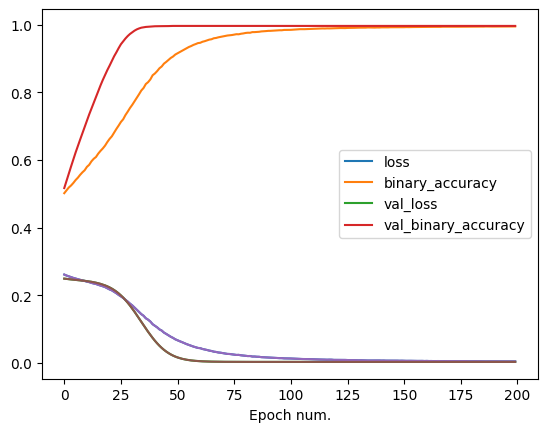

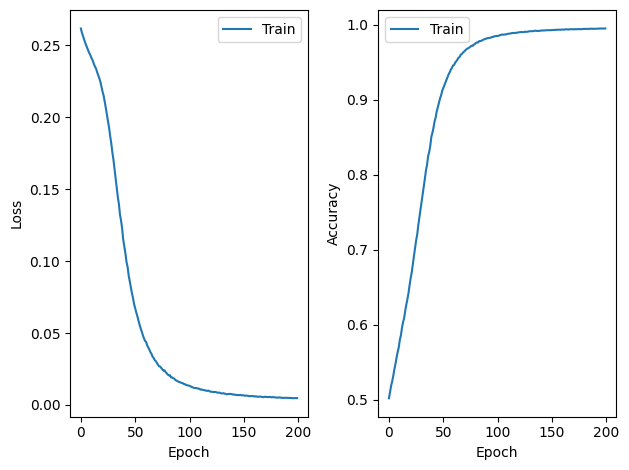

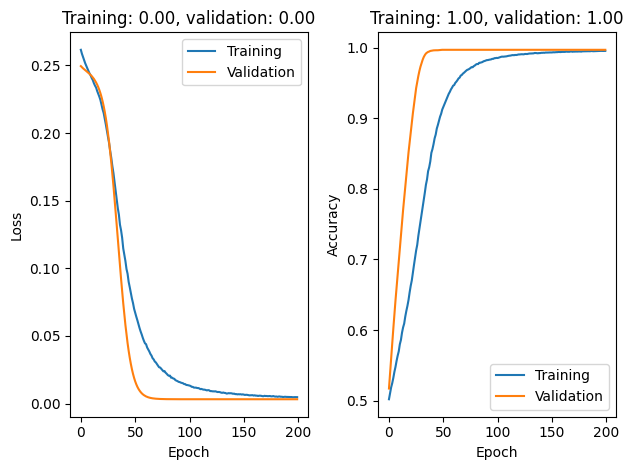

In [252]:
pd.DataFrame(cnn_history.history).plot()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch num.')
plt.show()

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['binary_accuracy'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {cnn_history.history["loss"][-1]:.2f}, validation: {cnn_history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['binary_accuracy'], label='Training')
plt.plot(cnn_history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {cnn_history.history["binary_accuracy"][-1]:.2f}, validation: {cnn_history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

Ahora veamos como saca los datos con otro conjunto (aviso, nosotros lo hemos hecho con parte del mismo conjunto por falta de datos, tenemos 448 artículos, no más)

In [49]:
titulosEficientesTest = x_test.title.fillna('DUMMY_VALUE').values
abstractsEficientesTest = x_test.abstract.fillna('DUMMY_VALUE').values

sentencesTest = [ (title +". "+ abstract) for title, abstract in zip(titulosEficientesTest, abstractsEficientesTest)]

print(len(x_test))
print(len(sentencesTest))
sentencesTest = list(sentencesTest)
print(len(sentencesTest))
print(sentencesTest)

44
44
44
['Scalable Learning of Entity and Predicate Embeddings for Knowledge Graph Completion. Knowledge Graphs (KGs) are a widely used formalism for representing knowledge in the Web of Data. We focus on the problem of link prediction, i.e. predicting missing links in large knowledge graphs, so to discover new facts about the world. Representation learning models that embed entities and relation types in continuous vector spaces recently were used to achieve new state-of-the-art link prediction results. A limiting factor in these models is that the process of learning the optimal embedding vectors can be really time-consuming, and might even require days of computations for large KGs. In this work, we propose a principled method for sensibly reducing the learning time, while converging to more accurate link prediction models. Furthermore, we employ the proposed method for training and evaluating a set of novel and scalable models. Our extensive evaluations show significant improvemen

In [50]:
test_sequences = tokenizer.texts_to_sequences(sentencesTest)
test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences,
    value=0,
    padding='post',
    maxlen=MAX_SEQUENCE_LENGTH
)

In [256]:
cnn_loss, cnn_acc = model.evaluate(test_data, salidaEsperadaCompressedAjustadaTest)

2/2 [==============================] - 0s 8ms/step - loss: 0.0031 - binary_accuracy: 0.9969


Ahora tras haberlo entrenado lo guardamos

In [110]:
from keras.models import load_model

In [258]:
model.save("cnn-Algigantix.h5") # guardar

In [222]:
model = load_model("cnn-Algigantix.h5") # cargar 

Ahora, para sacar solo 5 keywords, metemos la capa final en un for

In [55]:
# creamos una copia con los 5 valores más altos de toda la salida
def getMaxValues(myList, quantity):
    return sorted(list(set(myList)), reverse = True)[:quantity]

In [262]:
indicesDe5 = [diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"]]
print(indicesDe5)

f_output_cnn = model.predict(np.array([test_data[0]]))

for i in test_data[0]:
    if i != 0:
        print(index_word[i], end = " ")
print(type(f_output_cnn))
print(f_output_cnn)
abc = f_output_cnn[0].tolist()

los5valoresmasAltos = getMaxValues(abc, 5)
print(los5valoresmasAltos)

i = 0
k = 0
while i < len(los5valoresmasAltos):
    aux = np.where(f_output_cnn == los5valoresmasAltos[k])
    print(aux)
    print("ITERACION")
    k = k + 1
    j = 1
    while i < len(los5valoresmasAltos) and j < len(aux) :
        print(aux[j][0])
        indicesDe5[i] = aux[j][0]
        i = i +1
        j = j +1

# Y los pasamos a un formato que funcione
print(indicesDe5)
for i in indicesDe5:
    print(diccionarioKeywordsInvert[i])

print("ORIGINALES:")
indexao = 0
for i in salidaEsperadaCompressedAjustadaTest[0]:
    if i == 1:
        print(indexao)
        print(diccionarioKeywordsInvert[indexao])
    indexao += 1


[0, 0, 0, 0, 0]
1/1 [==============================] - 0s 17ms/step
comparative evaluation of top n recommenders in e commerce an industrial perspective we experiment on two real e commerce datasets and survey more than 30 popular e commerce platforms to reveal what methods work best for product recommendations in industrial settings despite recent academic advances in the field we observe that simple methods such as best seller lists dominate deployed recommendation engines in e commerce we find our empirical findings to be well aligned with those of the survey where in both cases simple personalized recommenders achieve higher ranking than more advanced techniques we also compare the traditional random evaluation protocol to our proposed chronological sampling method which can be used for determining the optimal time span of the training history for optimizing the performance of algorithms this performance is also affected by a proper hyperparameter tuning for which we propose golden

Como vemos, arriba algo va mal, ya que tras comprobar cuales son los de mayor valor, no solo nos dice unos que no son, ¡pero son unos valores bastante bajos! Esto se debe my probablemente al gran número de salidas que son 0 y la red decidio que estadísticamente el 0 es lo más acertado. De hecho al multiplicar 0.0032 del loss por las 1535 claves que tenemos nos sale que efectivamente 4-5 de las claves están mal... las que serían unos. Este entrenamiento no nos sirve tal y como está.

Sabemos que parte del problema se debe a que los datos no son los mejores, de hecho existen algunos caracteres extraños que podrían introducir errores el los datos de entrada por incluir palabras nuevas o variaciones de palabras; pero más importante, que las etiquetas del documento de entrenamiento fueron añadidas por usuarios sin poner etiquetass similares, por lo que naturalmente hay pocas repeticiones de la misma etiqueta (¡¡¡de un total de 2126 claves recogidas en los artículos, hay 1535 únicas, lo cual supone que de media no todas las claves van a repetirse!!!) y entonces se vuelve muy complicado sacar algo de esto. Pero antes de tratar esos datos manualmente probaremos a ver si podemos mejorar la técnica de entrenamiento en sí.

Así que decidimos probar otro método, basado en falsos negativos, con la (poca, teniendo en cuenta lo mencionada de la basura del conjunto de datos) esperanza de que tras cierto número de epochs en cuanto el error bajase lo suficiente comenzase a elevar los unos que realmente importaban.

In [154]:
#Método 2, falseNegatives
cnn_history = model.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs=600,
    validation_split=0.1,
    callbacks=[checkpoint, tb_callback]
)

Epoch 1/600
13/13 [==============================] - 3s 158ms/step - loss: 0.2758 - false_negatives_2: 988.0000 - val_loss: 0.2498 - val_false_negatives_2: 103.0000
Epoch 2/600
13/13 [==============================] - 1s 104ms/step - loss: 0.2706 - false_negatives_2: 952.0000 - val_loss: 0.2486 - val_false_negatives_2: 106.0000
Epoch 3/600
13/13 [==============================] - 1s 80ms/step - loss: 0.2664 - false_negatives_2: 1018.0000 - val_loss: 0.2476 - val_false_negatives_2: 109.0000
Epoch 4/600
13/13 [==============================] - 1s 93ms/step - loss: 0.2622 - false_negatives_2: 989.0000 - val_loss: 0.2467 - val_false_negatives_2: 115.0000
Epoch 5/600
13/13 [==============================] - 1s 86ms/step - loss: 0.2594 - false_negatives_2: 1027.0000 - val_loss: 0.2458 - val_false_negatives_2: 121.0000
Epoch 6/600
13/13 [==============================] - 2s 124ms/step - loss: 0.2554 - false_negatives_2: 999.0000 - val_loss: 0.2450 - val_false_negatives_2: 125.0000
Epoch 7/600

13/13 [==============================] - 1s 80ms/step - loss: 0.0166 - false_negatives_2: 1867.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 100/600
13/13 [==============================] - 2s 130ms/step - loss: 0.0159 - false_negatives_2: 1872.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 101/600
13/13 [==============================] - 1s 86ms/step - loss: 0.0159 - false_negatives_2: 1870.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 102/600
13/13 [==============================] - 1s 103ms/step - loss: 0.0152 - false_negatives_2: 1871.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 103/600
13/13 [==============================] - 2s 129ms/step - loss: 0.0155 - false_negatives_2: 1874.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 104/600
13/13 [==============================] - 1s 87ms/step - loss: 0.0150 - false_negatives_2: 1868.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 105

13/13 [==============================] - 1s 90ms/step - loss: 0.0053 - false_negatives_2: 1897.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 198/600
13/13 [==============================] - 1s 85ms/step - loss: 0.0053 - false_negatives_2: 1897.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 199/600
13/13 [==============================] - 1s 73ms/step - loss: 0.0051 - false_negatives_2: 1895.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 200/600
13/13 [==============================] - 1s 75ms/step - loss: 0.0052 - false_negatives_2: 1900.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 201/600
13/13 [==============================] - 1s 81ms/step - loss: 0.0050 - false_negatives_2: 1895.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 202/600
13/13 [==============================] - 1s 88ms/step - loss: 0.0052 - false_negatives_2: 1900.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 203/60

13/13 [==============================] - 1s 114ms/step - loss: 0.0037 - false_negatives_2: 1898.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 296/600
13/13 [==============================] - 2s 127ms/step - loss: 0.0037 - false_negatives_2: 1901.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 297/600
13/13 [==============================] - 1s 86ms/step - loss: 0.0037 - false_negatives_2: 1899.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 298/600
13/13 [==============================] - 1s 98ms/step - loss: 0.0037 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 299/600
13/13 [==============================] - 2s 146ms/step - loss: 0.0037 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 300/600
13/13 [==============================] - 1s 86ms/step - loss: 0.0038 - false_negatives_2: 1901.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 301

13/13 [==============================] - 1s 104ms/step - loss: 0.0035 - false_negatives_2: 1900.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 345/600
13/13 [==============================] - 1s 83ms/step - loss: 0.0036 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 346/600
13/13 [==============================] - 1s 86ms/step - loss: 0.0035 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 347/600
13/13 [==============================] - 1s 84ms/step - loss: 0.0036 - false_negatives_2: 1900.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 348/600
13/13 [==============================] - 1s 77ms/step - loss: 0.0036 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 349/600
13/13 [==============================] - 1s 88ms/step - loss: 0.0035 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 350/6

13/13 [==============================] - 1s 86ms/step - loss: 0.0034 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 394/600
13/13 [==============================] - 1s 89ms/step - loss: 0.0034 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 395/600
13/13 [==============================] - 1s 119ms/step - loss: 0.0034 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 396/600
13/13 [==============================] - 1s 100ms/step - loss: 0.0034 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 397/600
13/13 [==============================] - 1s 88ms/step - loss: 0.0034 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 398/600
13/13 [==============================] - 1s 88ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 399/

13/13 [==============================] - 1s 83ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 443/600
13/13 [==============================] - 2s 136ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 444/600
13/13 [==============================] - 1s 97ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 445/600
13/13 [==============================] - 1s 82ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 446/600
13/13 [==============================] - 1s 90ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 447/600
13/13 [==============================] - 1s 92ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 448/6

13/13 [==============================] - 1s 91ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 492/600
13/13 [==============================] - 1s 85ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 493/600
13/13 [==============================] - 1s 85ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 494/600
13/13 [==============================] - 1s 104ms/step - loss: 0.0033 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 495/600
13/13 [==============================] - 1s 100ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 496/600
13/13 [==============================] - 1s 99ms/step - loss: 0.0032 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 497/

13/13 [==============================] - 1s 84ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 541/600
13/13 [==============================] - 1s 88ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 542/600
13/13 [==============================] - 1s 90ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 543/600
13/13 [==============================] - 1s 106ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 544/600
13/13 [==============================] - 1s 94ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 545/600
13/13 [==============================] - 1s 100ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 546/

13/13 [==============================] - 1s 81ms/step - loss: 0.0032 - false_negatives_2: 1901.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 590/600
13/13 [==============================] - 1s 93ms/step - loss: 0.0032 - false_negatives_2: 1902.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 591/600
13/13 [==============================] - 1s 106ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 592/600
13/13 [==============================] - 1s 106ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 593/600
13/13 [==============================] - 1s 87ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 594/600
13/13 [==============================] - 1s 90ms/step - loss: 0.0032 - false_negatives_2: 1903.0000 - val_loss: 0.0032 - val_false_negatives_2: 222.0000
Epoch 595/

Esto tampoco funcionó, así que tratamos de probar por recall, que en teoría hacía lo mismo, con mismos planes.

In [221]:
#Método 3, recall, de la que curiosamente no existe el "recall"
cnn_history = model.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs=600,
    validation_split=0.1,
    callbacks=[checkpoint, tb_callback]
)

Epoch 1/600
13/13 [==============================] - 4s 170ms/step - loss: 0.2655 - recall_5: 0.4924 - val_loss: 0.2491 - val_recall_5: 0.4189
Epoch 2/600
13/13 [==============================] - 2s 156ms/step - loss: 0.2610 - recall_5: 0.4997 - val_loss: 0.2481 - val_recall_5: 0.3964
Epoch 3/600
13/13 [==============================] - 2s 142ms/step - loss: 0.2578 - recall_5: 0.4887 - val_loss: 0.2473 - val_recall_5: 0.3919
Epoch 4/600
13/13 [==============================] - 2s 146ms/step - loss: 0.2550 - recall_5: 0.4677 - val_loss: 0.2465 - val_recall_5: 0.3739
Epoch 5/600
13/13 [==============================] - 2s 158ms/step - loss: 0.2526 - recall_5: 0.4698 - val_loss: 0.2458 - val_recall_5: 0.3649
Epoch 6/600
13/13 [==============================] - 2s 147ms/step - loss: 0.2501 - recall_5: 0.4661 - val_loss: 0.2451 - val_recall_5: 0.3649
Epoch 7/600
13/13 [==============================] - 2s 148ms/step - loss: 0.2477 - recall_5: 0.4414 - val_loss: 0.2444 - val_recall_5: 0.3468

13/13 [==============================] - 2s 145ms/step - loss: 0.0116 - recall_5: 0.0084 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 113/600
13/13 [==============================] - 2s 151ms/step - loss: 0.0114 - recall_5: 0.0079 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 114/600
13/13 [==============================] - 2s 145ms/step - loss: 0.0113 - recall_5: 0.0110 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 115/600
13/13 [==============================] - 2s 147ms/step - loss: 0.0114 - recall_5: 0.0105 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 116/600
13/13 [==============================] - 2s 153ms/step - loss: 0.0106 - recall_5: 0.0084 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 117/600
13/13 [==============================] - 2s 143ms/step - loss: 0.0106 - recall_5: 0.0084 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 118/600
13/13 [==============================] - 2s 141ms/step - loss: 0.0103 - recall_5: 0.0100 - val_loss: 0.003

13/13 [==============================] - 2s 139ms/step - loss: 0.0059 - recall_5: 0.0037 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 168/600
13/13 [==============================] - 2s 141ms/step - loss: 0.0059 - recall_5: 0.0032 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 169/600
13/13 [==============================] - 2s 150ms/step - loss: 0.0059 - recall_5: 0.0021 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 170/600
13/13 [==============================] - 2s 151ms/step - loss: 0.0061 - recall_5: 0.0047 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 171/600
13/13 [==============================] - 2s 142ms/step - loss: 0.0059 - recall_5: 0.0026 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 172/600
13/13 [==============================] - 2s 146ms/step - loss: 0.0058 - recall_5: 0.0032 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 173/600
13/13 [==============================] - 2s 138ms/step - loss: 0.0060 - recall_5: 0.0037 - val_loss: 0.003

Epoch 222/600
13/13 [==============================] - 2s 152ms/step - loss: 0.0044 - recall_5: 0.0032 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 223/600
13/13 [==============================] - 2s 154ms/step - loss: 0.0044 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 224/600
13/13 [==============================] - 2s 157ms/step - loss: 0.0044 - recall_5: 0.0021 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 225/600
13/13 [==============================] - 2s 152ms/step - loss: 0.0044 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 226/600
13/13 [==============================] - 2s 158ms/step - loss: 0.0043 - recall_5: 0.0032 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 227/600
13/13 [==============================] - 2s 154ms/step - loss: 0.0046 - recall_5: 0.0026 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 228/600
13/13 [==============================] - 2s 156ms/step - loss: 0.0043 - recall_5: 0.0021 - v

13/13 [==============================] - 2s 145ms/step - loss: 0.0036 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 331/600
13/13 [==============================] - 2s 138ms/step - loss: 0.0036 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 332/600
13/13 [==============================] - 2s 149ms/step - loss: 0.0036 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 333/600
13/13 [==============================] - 2s 144ms/step - loss: 0.0036 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 334/600
13/13 [==============================] - 2s 144ms/step - loss: 0.0035 - recall_5: 5.2549e-04 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 335/600
13/13 [==============================] - 2s 145ms/step - loss: 0.0035 - recall_5: 5.2549e-04 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 336/600
13/13 [==============================] - 2s 146ms/step - loss: 0.0036 - recall_5: 0.0000e+00 -

13/13 [==============================] - 2s 146ms/step - loss: 0.0033 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 385/600
13/13 [==============================] - 2s 139ms/step - loss: 0.0034 - recall_5: 5.2549e-04 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 386/600
13/13 [==============================] - 2s 143ms/step - loss: 0.0034 - recall_5: 5.2549e-04 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 387/600
13/13 [==============================] - 2s 150ms/step - loss: 0.0034 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 388/600
13/13 [==============================] - 2s 153ms/step - loss: 0.0033 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 389/600
13/13 [==============================] - 2s 157ms/step - loss: 0.0034 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 390/600
13/13 [==============================] - 2s 154ms/step - loss: 0.0033 - recall_5: 0.0000e+

Epoch 438/600
13/13 [==============================] - 2s 141ms/step - loss: 0.0033 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 439/600
13/13 [==============================] - 2s 141ms/step - loss: 0.0033 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 440/600
13/13 [==============================] - 2s 146ms/step - loss: 0.0032 - recall_5: 0.0011 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 441/600
13/13 [==============================] - 2s 144ms/step - loss: 0.0033 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 442/600
13/13 [==============================] - 2s 151ms/step - loss: 0.0033 - recall_5: 5.2549e-04 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 443/600
13/13 [==============================] - 2s 151ms/step - loss: 0.0033 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 444/600
13/13 [==============================] - 2s 149ms/step - loss: 0.0033 - 

Epoch 545/600
13/13 [==============================] - 1s 78ms/step - loss: 0.0032 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 546/600
13/13 [==============================] - 1s 74ms/step - loss: 0.0032 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 547/600
13/13 [==============================] - 1s 79ms/step - loss: 0.0032 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 548/600
13/13 [==============================] - 1s 78ms/step - loss: 0.0032 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 549/600
13/13 [==============================] - 1s 76ms/step - loss: 0.0032 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 550/600
13/13 [==============================] - 1s 77ms/step - loss: 0.0032 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 551/600
13/13 [==============================] - 1s 76ms/step - loss: 0.0032 - rec

Epoch 599/600
13/13 [==============================] - 1s 74ms/step - loss: 0.0031 - recall_5: 0.0000e+00 - val_loss: 0.0032 - val_recall_5: 0.0000e+00
Epoch 600/600
13/13 [==============================] - 1s 76ms/step - loss: 0.0032 - recall_5: 5.2549e-04 - val_loss: 0.0032 - val_recall_5: 0.0000e+00


Como eso tampoco funcionó, probamos con f1_score, que por complicaciones extrañas tuvimos que incluir manualmente la primera vez

In [38]:
#Método 4, f1_score
cnn_history = model.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs=600,
    validation_split=0.1,
    callbacks=[checkpoint] # tensorboard no funciona con esto adecuadamente
)

Epoch 1/600
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
13/13 [==============================] - 2s 41ms/step - loss: 0.2689 - f1_score: 0.0060 - val_loss: 0.2490 - val_f1_score: 0.0046
Epoch 2/600
13/13 [==============================] - 0s 30ms/step - loss: 0.2641 - f1_score: 0.0060 - val_loss: 0.2478 - val_f1_score: 0.0043
Epoch 3/600
13/13 [==============================] - 0s 29ms/step - loss: 0.2608 - f1_score: 0.0062 - val_loss: 0.2469 - val_f1_score: 0.0043
Epoch 4/600
13/13 [==============================] - 0s 28ms/step - loss: 0.2574 - f1_score: 0.0060 - val_loss: 0.2460 - val_f1_score: 0.0045
Epoch 5/600
13/13 [==============================] - 0s 29ms/step - loss: 0.2539 - f1_score: 0.0062 - val_loss: 0.2451 - val_f1_score: 0.0040
Epoch 6/600
13/13 [==============================] - 0s 29ms/step - loss: 0.2511 - f1_sco

Epoch 110/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0125 - f1_score: 0.0058 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 111/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0126 - f1_score: 0.0032 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 112/600
13/13 [==============================] - 0s 33ms/step - loss: 0.0120 - f1_score: 0.0047 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 113/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0120 - f1_score: 0.0047 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 114/600
13/13 [==============================] - 0s 34ms/step - loss: 0.0115 - f1_score: 0.0032 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 115/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0115 - f1_score: 0.0033 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 116/600
13/13 [==============================] - 0s 34ms/step - loss: 0.0114 - f1_score: 0.0030 - val_loss

13/13 [==============================] - 0s 28ms/step - loss: 0.0046 - f1_score: 0.0017 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 221/600
13/13 [==============================] - 0s 27ms/step - loss: 0.0045 - f1_score: 0.0013 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 222/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0046 - f1_score: 2.1716e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 223/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0045 - f1_score: 0.0014 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 224/600
13/13 [==============================] - 0s 27ms/step - loss: 0.0045 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 225/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0045 - f1_score: 8.6862e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 226/600
13/13 [==============================] - 0s 27ms/step - loss: 0.0046 - f1_score: 8.6862e-04 - val_lo

Epoch 275/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0039 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 276/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0039 - f1_score: 0.0018 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 277/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0039 - f1_score: 0.0019 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 278/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0040 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 279/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0040 - f1_score: 2.4278e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 280/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0039 - f1_score: 0.0013 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 281/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0039 - f1_score: 0.000

13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 6.5147e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 384/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 385/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 2.1716e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 386/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 387/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 388/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 389/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0034 - f1_score: 0.0000e

13/13 [==============================] - 0s 29ms/step - loss: 0.0033 - f1_score: 6.5147e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 438/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0033 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 439/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0033 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 440/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0033 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 441/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0033 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 442/600
13/13 [==============================] - 0s 34ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 443/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0033 - f1_score: 0.0000e

13/13 [==============================] - 0s 33ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 492/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0033 - f1_score: 4.3431e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 493/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0032 - f1_score: 8.6862e-05 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 494/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 495/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 496/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0033 - f1_score: 6.5147e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 497/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0032 - f1_score: 0.0000e

13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 546/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 547/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 548/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 549/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - f1_score: 6.5147e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 550/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0032 - f1_score: 6.5147e-04 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 551/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0032 - f1_score: 0.0000e

Epoch 599/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 600/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0032 - f1_score: 0.0000e+00 - val_loss: 0.0032 - val_f1_score: 0.0000e+00


Probemos con otro loss, como binary_crossentropy sobre F1Score, y aumentemos factor de aprendizaje

In [76]:
print("Iniciando red de Convolución")
#print(f"La shape de entrada es: {len(entradaEntrenamiento)} artículos, {len(entradaEntrenamiento[0])} palabras por artículo, {len(entradaEntrenamiento[0][0])} caracteres por palabra")
print(f"La salida esperada tiene dimensiones {len(salidaEsperadaCompressedAjustada)} artículos, {len(salidaEsperadaCompressedAjustada[0])} claves")

LOAD_PREVIOUS = False

checkpoints = sorted(glob.glob('cnn-Algigantix/*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    
    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, )) # len(entradaEntrenamiento[0][0])
    x = embedding_layer(input_)
    x = tf.keras.layers.Conv1D(32, kernel_size=2, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    
    x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(x)

    x = tf.keras.layers.Conv1D(16, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=4)(x)

    # La RRNN perceptrón multicapa, necesito aplanar
    x = tf.keras.layers.Flatten()(x)
#    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) # los dos de abajo son extra
    x = tf.keras.layers.Dropout(0.9)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x) # Pasar de 32 a 1024 ha hecho que al menos en 3 epochs vaya algo mejor originalmente meti 5296
    x = tf.keras.layers.Dropout(0.8)(x) # tenía 0.8, probemos con 0.99

    output = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation = 'sigmoid')(x) # softmax # sigmoid # usar categorical solo nos devuelve uno entre muchos

    model = tf.keras.Model(input_, output)

model.compile(
    loss= "binary_crossentropy", #tf.keras.losses.KLDivergence(), #tf.keras.losses.Poisson(), #'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #learning_rate=0.000001, beta_1=0.9, beta_2=0.999, , clipnorm=1.0, clipvalue=5.0), 
    # Para las métricas no podemos utilizar categorical_accuracy puesto que el entrenamiento es también con múltiples categorías de salida válidas, no solo una
    # también sabemos que accuracy tampoco nos valdría, porque casi siempre arrojaría ceros incluso aunque nos acercásemos a la solución
    # NÓTSE HEMOS ESTADO COMENTANDO Y DESCOMENTANDO LAS DE ABAJO PARA MODELAR, MOSTRANDO LOS RESULTADOS ABAJO
    # Método 1, binary_accuracy
    #metrics= ['binary_accuracy']
    # Método 2, falsos negativos.
    #metrics= [tf.keras.metrics.FalseNegatives()] 
    #]#[]#["accuracy"] #[tf.keras.metrics.Accuracy()]#[tf.keras.metrics.CategoricalAccuracy()]
    #Método 3, recall
    #metrics = [tf.keras.metrics.Recall()]
    #Método 4: Acá abajo la de F1score que tuvimos que codificar
    metrics= [tensorflow_addons.metrics.f_scores.F1Score(num_classes=len(matrizSalidaSinKeywords), threshold=0.5)]
    
)
model.summary()

print('done')

Iniciando red de Convolución
La salida esperada tiene dimensiones 448 artículos, 1535 claves
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 conv1d_24 (Conv1D)          (None, 332, 32)           12832     
                                                                 
 conv1d_25 (Conv1D)          (None, 330, 16)           1552      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 110, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (N

In [77]:
cnn_history = model.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs=600,
    validation_split=0.1,
    #callbacks=[checkpoint] # tensorboard no funciona con esto adecuadamente
)

Epoch 1/600
13/13 [==============================] - 1s 46ms/step - loss: 0.7214 - f1_score: 0.0061 - val_loss: 0.6771 - val_f1_score: 0.0024
Epoch 2/600
13/13 [==============================] - 0s 30ms/step - loss: 0.6583 - f1_score: 0.0059 - val_loss: 0.6634 - val_f1_score: 0.0018
Epoch 3/600
13/13 [==============================] - 0s 30ms/step - loss: 0.6162 - f1_score: 0.0061 - val_loss: 0.6273 - val_f1_score: 5.9129e-04
Epoch 4/600
13/13 [==============================] - 0s 30ms/step - loss: 0.5479 - f1_score: 0.0057 - val_loss: 0.5264 - val_f1_score: 1.3678e-04
Epoch 5/600
13/13 [==============================] - 0s 30ms/step - loss: 0.4277 - f1_score: 0.0059 - val_loss: 0.3193 - val_f1_score: 0.0000e+00
Epoch 6/600
13/13 [==============================] - 0s 29ms/step - loss: 0.2866 - f1_score: 0.0054 - val_loss: 0.1130 - val_f1_score: 0.0000e+00
Epoch 7/600
13/13 [==============================] - 0s 30ms/step - loss: 0.1719 - f1_score: 0.0059 - val_loss: 0.0359 - val_f1_scor

13/13 [==============================] - 0s 30ms/step - loss: 0.0273 - f1_score: 3.2072e-04 - val_loss: 0.0238 - val_f1_score: 0.0000e+00
Epoch 57/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0267 - f1_score: 1.0407e-04 - val_loss: 0.0237 - val_f1_score: 0.0000e+00
Epoch 58/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0270 - f1_score: 0.0000e+00 - val_loss: 0.0238 - val_f1_score: 0.0000e+00
Epoch 59/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0269 - f1_score: 2.0358e-05 - val_loss: 0.0238 - val_f1_score: 0.0000e+00
Epoch 60/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0265 - f1_score: 3.8322e-05 - val_loss: 0.0237 - val_f1_score: 0.0000e+00
Epoch 61/600
13/13 [==============================] - 0s 34ms/step - loss: 0.0266 - f1_score: 7.7787e-05 - val_loss: 0.0237 - val_f1_score: 0.0000e+00
Epoch 62/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0266 - f1_score: 2.2628e-04 - 

Epoch 164/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0227 - f1_score: 2.5548e-05 - val_loss: 0.0245 - val_f1_score: 0.0000e+00
Epoch 165/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0230 - f1_score: 0.0000e+00 - val_loss: 0.0251 - val_f1_score: 0.0000e+00
Epoch 166/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0228 - f1_score: 2.5056e-05 - val_loss: 0.0247 - val_f1_score: 0.0000e+00
Epoch 167/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0226 - f1_score: 0.0000e+00 - val_loss: 0.0250 - val_f1_score: 0.0000e+00
Epoch 168/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0227 - f1_score: 2.6059e-05 - val_loss: 0.0243 - val_f1_score: 0.0000e+00
Epoch 169/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0228 - f1_score: 0.0000e+00 - val_loss: 0.0250 - val_f1_score: 0.0000e+00
Epoch 170/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0227 - f1_

Epoch 218/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0222 - f1_score: 0.0000e+00 - val_loss: 0.0253 - val_f1_score: 0.0000e+00
Epoch 219/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0222 - f1_score: 0.0000e+00 - val_loss: 0.0258 - val_f1_score: 0.0000e+00
Epoch 220/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0222 - f1_score: 0.0000e+00 - val_loss: 0.0253 - val_f1_score: 0.0000e+00
Epoch 221/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0222 - f1_score: 0.0000e+00 - val_loss: 0.0255 - val_f1_score: 0.0000e+00
Epoch 222/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0221 - f1_score: 0.0000e+00 - val_loss: 0.0252 - val_f1_score: 0.0000e+00
Epoch 223/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0222 - f1_score: 0.0000e+00 - val_loss: 0.0257 - val_f1_score: 0.0000e+00
Epoch 224/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0222 - f1_

Epoch 272/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0217 - f1_score: 0.0000e+00 - val_loss: 0.0264 - val_f1_score: 0.0000e+00
Epoch 273/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0218 - f1_score: 0.0000e+00 - val_loss: 0.0259 - val_f1_score: 0.0000e+00
Epoch 274/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0218 - f1_score: 0.0000e+00 - val_loss: 0.0262 - val_f1_score: 0.0000e+00
Epoch 275/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0217 - f1_score: 0.0000e+00 - val_loss: 0.0259 - val_f1_score: 0.0000e+00
Epoch 276/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0220 - f1_score: 0.0000e+00 - val_loss: 0.0260 - val_f1_score: 0.0000e+00
Epoch 277/600
13/13 [==============================] - 0s 28ms/step - loss: 0.0220 - f1_score: 0.0000e+00 - val_loss: 0.0262 - val_f1_score: 0.0000e+00
Epoch 278/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0218 - f1_

Epoch 326/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0215 - f1_score: 0.0000e+00 - val_loss: 0.0268 - val_f1_score: 0.0000e+00
Epoch 327/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0213 - f1_score: 0.0000e+00 - val_loss: 0.0265 - val_f1_score: 0.0000e+00
Epoch 328/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0214 - f1_score: 0.0000e+00 - val_loss: 0.0267 - val_f1_score: 0.0000e+00
Epoch 329/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0216 - f1_score: 0.0000e+00 - val_loss: 0.0266 - val_f1_score: 0.0000e+00
Epoch 330/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0217 - f1_score: 0.0000e+00 - val_loss: 0.0268 - val_f1_score: 0.0000e+00
Epoch 331/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0213 - f1_score: 0.0000e+00 - val_loss: 0.0267 - val_f1_score: 0.0000e+00
Epoch 332/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0214 - f1_

Epoch 380/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0211 - f1_score: 0.0000e+00 - val_loss: 0.0272 - val_f1_score: 0.0000e+00
Epoch 381/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0212 - f1_score: 0.0000e+00 - val_loss: 0.0272 - val_f1_score: 0.0000e+00
Epoch 382/600
13/13 [==============================] - 0s 33ms/step - loss: 0.0211 - f1_score: 0.0000e+00 - val_loss: 0.0276 - val_f1_score: 0.0000e+00
Epoch 383/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0212 - f1_score: 0.0000e+00 - val_loss: 0.0270 - val_f1_score: 0.0000e+00
Epoch 384/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0211 - f1_score: 0.0000e+00 - val_loss: 0.0272 - val_f1_score: 0.0000e+00
Epoch 385/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0212 - f1_score: 0.0000e+00 - val_loss: 0.0273 - val_f1_score: 0.0000e+00
Epoch 386/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0212 - f1_

Epoch 434/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0209 - f1_score: 0.0000e+00 - val_loss: 0.0277 - val_f1_score: 0.0000e+00
Epoch 435/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0208 - f1_score: 0.0000e+00 - val_loss: 0.0279 - val_f1_score: 0.0000e+00
Epoch 436/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0210 - f1_score: 0.0000e+00 - val_loss: 0.0278 - val_f1_score: 0.0000e+00
Epoch 437/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0210 - f1_score: 0.0000e+00 - val_loss: 0.0279 - val_f1_score: 0.0000e+00
Epoch 438/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0211 - f1_score: 0.0000e+00 - val_loss: 0.0280 - val_f1_score: 0.0000e+00
Epoch 439/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0209 - f1_score: 0.0000e+00 - val_loss: 0.0279 - val_f1_score: 0.0000e+00
Epoch 440/600
13/13 [==============================] - 0s 30ms/step - loss: 0.0208 - f1_

Epoch 488/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0209 - f1_score: 0.0000e+00 - val_loss: 0.0285 - val_f1_score: 0.0000e+00
Epoch 489/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0206 - f1_score: 0.0000e+00 - val_loss: 0.0282 - val_f1_score: 0.0000e+00
Epoch 490/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0208 - f1_score: 0.0000e+00 - val_loss: 0.0285 - val_f1_score: 0.0000e+00
Epoch 491/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0208 - f1_score: 0.0000e+00 - val_loss: 0.0283 - val_f1_score: 0.0000e+00
Epoch 492/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0208 - f1_score: 0.0000e+00 - val_loss: 0.0288 - val_f1_score: 0.0000e+00
Epoch 493/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0208 - f1_score: 0.0000e+00 - val_loss: 0.0284 - val_f1_score: 0.0000e+00
Epoch 494/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0207 - f1_

Epoch 542/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0204 - f1_score: 0.0000e+00 - val_loss: 0.0286 - val_f1_score: 0.0000e+00
Epoch 543/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0203 - f1_score: 0.0000e+00 - val_loss: 0.0288 - val_f1_score: 0.0000e+00
Epoch 544/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0204 - f1_score: 0.0000e+00 - val_loss: 0.0292 - val_f1_score: 0.0000e+00
Epoch 545/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0204 - f1_score: 0.0000e+00 - val_loss: 0.0287 - val_f1_score: 0.0000e+00
Epoch 546/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0204 - f1_score: 0.0000e+00 - val_loss: 0.0292 - val_f1_score: 0.0000e+00
Epoch 547/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0204 - f1_score: 0.0000e+00 - val_loss: 0.0289 - val_f1_score: 0.0000e+00
Epoch 548/600
13/13 [==============================] - 0s 29ms/step - loss: 0.0203 - f1_

Epoch 596/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0200 - f1_score: 0.0000e+00 - val_loss: 0.0296 - val_f1_score: 0.0000e+00
Epoch 597/600
13/13 [==============================] - 0s 31ms/step - loss: 0.0199 - f1_score: 0.0000e+00 - val_loss: 0.0295 - val_f1_score: 0.0000e+00
Epoch 598/600
13/13 [==============================] - 0s 32ms/step - loss: 0.0200 - f1_score: 0.0000e+00 - val_loss: 0.0297 - val_f1_score: 0.0000e+00
Epoch 599/600
13/13 [==============================] - 0s 34ms/step - loss: 0.0200 - f1_score: 0.0000e+00 - val_loss: 0.0296 - val_f1_score: 0.0000e+00
Epoch 600/600
13/13 [==============================] - 0s 37ms/step - loss: 0.0200 - f1_score: 0.0000e+00 - val_loss: 0.0300 - val_f1_score: 0.0000e+00


Viendo que eso tampoco funcionaba, decidimos ya finalmente probar a editar el número de keywords de alguna forma
* Opción A: editar el fichero en sí manualmente y tratar de unir keywords similares. Este proceso podría ser mucho mejor que la opción B ya que el ser humano podría deducir heurísitcamente y del contexto categorías que fueran similares incluso aunque fuese por siglas, y una vez completado simplemente se iría arriba y se harían de nuevo los pasos anteriores; pero sería tremendamente tedioso y encima podríamos cometer gazapos y bias que podrían hacer la información más inservible.
* Opción B: introducir las keywords en un embedding propio entrenado previamente como GloVe, por ejemplo de dim=200, y luego sumamos los vectores de keywords para obtener un resultado neto final que es lo que meteríamos como salida esperada, en la que las salidas serían categorías semánticas. Se podría volver a binary-accuracy ya que en teoría muchas de las palabras tendrían la mayoría de campos no nulos. Sin embargo, esto tiene el problema de que múltiples keywords con diferentes matices podrían dar el mismo resultado neto. Además de que GloVe puede no tener las palabras adecuadas para ello.

Ambos casos requerirían alterar la estructura de output de la red.

Abajo se ponen dos ejemplos de como la red de embedding se realizaría, aunque como ya hemos mencionado, por lo mencionado anteriormente no podemos esperar que nos de buenos resultados

In [210]:
# OPCION DEL EMBEDDING
tokenizerKeyWord =   tf.keras.preprocessing.text.Tokenizer(num_words=WORDS_IN_VOCAB)
tokenizerKeyWord.fit_on_texts(listaTotalKeywordsPorArticulo)
sequencesKeyWord =   tokenizerKeyWord.texts_to_sequences(listaTotalKeywordsPorArticulo)
keyword_index =  tokenizerKeyWord.word_index
index_keyword = {index: word for word, index in keyword_index.items()}

print(sequencesKeyWord)
print('PADDING')
keywordsemanticdata = tf.keras.preprocessing.sequence.pad_sequences(
    sequencesKeyWord,
    value=0,
    maxlen=10 # supondremos hasta 10 categorías útiles para el
)
print(keywordsemanticdata)

print('Loading embedding with GloVe vectors... ', end='')
# Cargamos sólo las palabras elegidas de nuestro conjunto de datos
num_keywords = min(WORDS_IN_VOCAB, len(keyword_index) + 1)
embedding_keyword_matrix = np.zeros((num_keywords, EMBEDDING_DIM))
for word, i in keyword_index.items():
    if i < WORDS_IN_VOCAB:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_keyword_matrix[i] = embedding_vector
print('done')
print(num_keywords)
print(embedding_keyword_matrix)
# Creamos la capa de embedding
embedding_keyword_layer = tf.keras.layers.Embedding(
  input_dim=num_keywords,
  output_dim=EMBEDDING_DIM,
  weights=[embedding_keyword_matrix],
  input_length=10,
  trainable=False,
)
print('Embedding done')
#tf.keras.backend
special = K.sum(
    embedding_keyword_layer(keywordsemanticdata[-2]), axis=0, keepdims=False
)
print(embedding_keyword_layer(keywordsemanticdata[-2]))
print(embedding_keyword_layer(keywordsemanticdata[-2]).shape)
print("El especial")
print(special)
print(special.shape)

print(f'la shape del embedding es {embedding_keyword_layer(keywordsemanticdata[-2]).shape}')
#tf.keras.backend.sum(
#    embedding_keyword_layer, axis=None, keepdims=False
#)

salidaEsperadaCompressedVec = []
for articulo in keywordsemanticdata:
    unArticulo = K.sum(
    embedding_keyword_layer(articulo), axis=0, keepdims=False
    )
    salidaEsperadaCompressedVec.append(unArticulo)
#print(salidaEsperadaCompressedVec)
salidaEsperadaCompressedAjustadaVec = np.array(salidaEsperadaCompressedVec)
print(salidaEsperadaCompressedAjustadaVec)
print(len(salidaEsperadaCompressedAjustadaVec))
print(len(salidaEsperadaCompressedAjustadaVec[0]))
#print(type(data))
#print(type(salidaEsperadaCompressedAjustada))
print('done')

[[222, 33, 223], [224, 98, 99, 225, 100], [226, 227, 228, 101], [229, 230, 231], [34, 102, 232, 233, 35, 24], [25, 234, 103, 235], [26, 36, 236, 237], [238, 1, 239, 16, 240], [241, 242, 243, 2, 6, 244], [245, 246, 104], [247, 37, 248], [249, 9, 250, 10, 251], [252, 38, 61], [253, 9, 254], [39, 25, 62, 105, 17], [255, 256, 106], [18, 257, 258, 259], [260, 261, 262, 263], [264, 40, 265, 266], [267, 268, 269, 270, 107, 271], [272, 273, 274], [275, 276, 277, 63, 278], [64, 279], [11, 3, 65], [280, 4, 281], [64, 282], [283, 284, 285, 286, 287], [12, 9, 4], [1, 288, 4, 289], [108, 64], [290, 291, 292], [293, 294, 109, 295], [110, 41, 27, 296, 24, 297, 66], [298, 42, 299, 300, 301], [111, 302, 303, 304, 112], [305, 306, 307], [19, 308, 309, 310, 311], [312, 313, 19, 1, 314], [315, 113, 114], [43, 67, 27, 68, 24, 115, 6], [316, 317, 116, 318, 69, 44, 319], [320, 321, 322], [323, 324, 70, 2, 325, 326], [117, 7, 327, 328, 118, 45], [2, 329, 330], [331, 332, 333, 334], [335, 336], [337, 338, 339,

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.03245    -0.25266004  0.309528   ...  0.93513     0.231299
   0.03418998]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.1778699  -0.89431     0.273393   ... -0.659334   -0.01490998
  -0.39723104]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
448
200
done


In [212]:
#ESTA SERÍA LA RED DEL EMBEDDING
LOAD_PREVIOUS = False

checkpoints = sorted(glob.glob('cnn-Algigantix/*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    
    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, )) # len(entradaEntrenamiento[0][0])
    x = embedding_layer(input_)
    x = tf.keras.layers.Conv1D(32, kernel_size=2, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    
    x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(x)

    x = tf.keras.layers.Conv1D(16, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=4)(x)

    # La RRNN perceptrón multicapa, necesito aplanar
    x = tf.keras.layers.Flatten()(x)
#    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) # los dos de abajo son extra
    x = tf.keras.layers.Dropout(0.9)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x) # Pasar de 32 a 1024 ha hecho que al menos en 3 epochs vaya algo mejor originalmente meti 5296
    x = tf.keras.layers.Dropout(0.8)(x) # tenía 0.8, probemos con 0.99

    output = tf.keras.layers.Dense(len(salidaEsperadaCompressedAjustadaVec[0]), activation = 'sigmoid')(x) # softmax # sigmoid # usar categorical solo nos devuelve uno entre muchos

    model = tf.keras.Model(input_, output)

model.compile(
    loss= tf.keras.losses.MeanSquaredError(), #"binary_crossentropy" #tf.keras.losses.KLDivergence(), #tf.keras.losses.Poisson(), #'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), #learning_rate=0.000001, beta_1=0.9, beta_2=0.999, , clipnorm=1.0, clipvalue=5.0), 
    # Para las métricas no podemos utilizar categorical_accuracy puesto que el entrenamiento es también con múltiples categorías de salida válidas, no solo una
    # también sabemos que accuracy tampoco nos valdría, porque casi siempre arrojaría ceros incluso aunque nos acercásemos a la solución
    # Método 1, binary_accuracy
    metrics= ['binary_accuracy']
    # Método 2, falsos negativos.
    #metrics= [tf.keras.metrics.FalseNegatives()] 
    #]#[]#["accuracy"] #[tf.keras.metrics.Accuracy()]#[tf.keras.metrics.CategoricalAccuracy()]
    #Método 3, recall
    #metrics = [tf.keras.metrics.Recall()]
    # Acá abajo la de F1score que tuvimos que codificar
    #metrics= [F1Score(num_classes=len(matrizSalidaSinKeywords), threshold=0.5)]

)
model.summary()

#Método de binary-accuracy porque ahora ya sí podemos hacer cosas
cnn_history = model.fit(
    data,
    salidaEsperadaCompressedAjustadaVec,
    epochs=600,
    validation_split=0.1,
    callbacks=[checkpoint, tb_callback]
)
print('done')

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 conv1d_72 (Conv1D)          (None, 332, 32)           12832     
                                                                 
 conv1d_73 (Conv1D)          (None, 330, 16)           1552      
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 110, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_74 (Conv1D)          (None, 107, 16)           1040      
                                                          

Epoch 39/600
13/13 [==============================] - 1s 93ms/step - loss: 0.4551 - binary_accuracy: 0.3154 - val_loss: 0.4797 - val_binary_accuracy: 0.3766
Epoch 40/600
13/13 [==============================] - 1s 88ms/step - loss: 0.4524 - binary_accuracy: 0.3182 - val_loss: 0.4771 - val_binary_accuracy: 0.3770
Epoch 41/600
13/13 [==============================] - 1s 87ms/step - loss: 0.4490 - binary_accuracy: 0.3204 - val_loss: 0.4744 - val_binary_accuracy: 0.3784
Epoch 42/600
13/13 [==============================] - 1s 87ms/step - loss: 0.4474 - binary_accuracy: 0.3225 - val_loss: 0.4716 - val_binary_accuracy: 0.3790
Epoch 43/600
13/13 [==============================] - 1s 87ms/step - loss: 0.4457 - binary_accuracy: 0.3244 - val_loss: 0.4685 - val_binary_accuracy: 0.3800
Epoch 44/600
13/13 [==============================] - 1s 87ms/step - loss: 0.4423 - binary_accuracy: 0.3254 - val_loss: 0.4653 - val_binary_accuracy: 0.3807
Epoch 45/600
13/13 [==============================] - 1s 8

Epoch 143/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2937 - binary_accuracy: 0.4360 - val_loss: 0.3028 - val_binary_accuracy: 0.3960
Epoch 144/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2936 - binary_accuracy: 0.4380 - val_loss: 0.3028 - val_binary_accuracy: 0.3960
Epoch 145/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2913 - binary_accuracy: 0.4379 - val_loss: 0.3028 - val_binary_accuracy: 0.3960
Epoch 146/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2912 - binary_accuracy: 0.4384 - val_loss: 0.3029 - val_binary_accuracy: 0.3960
Epoch 147/600
13/13 [==============================] - 1s 90ms/step - loss: 0.2905 - binary_accuracy: 0.4381 - val_loss: 0.3029 - val_binary_accuracy: 0.3960
Epoch 148/600
13/13 [==============================] - 1s 85ms/step - loss: 0.2919 - binary_accuracy: 0.4381 - val_loss: 0.3029 - val_binary_accuracy: 0.3960
Epoch 149/600
13/13 [==============================]

Epoch 195/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2782 - binary_accuracy: 0.4471 - val_loss: 0.3044 - val_binary_accuracy: 0.3960
Epoch 196/600
13/13 [==============================] - 1s 87ms/step - loss: 0.2785 - binary_accuracy: 0.4477 - val_loss: 0.3044 - val_binary_accuracy: 0.3960
Epoch 197/600
13/13 [==============================] - 1s 87ms/step - loss: 0.2779 - binary_accuracy: 0.4482 - val_loss: 0.3044 - val_binary_accuracy: 0.3960
Epoch 198/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2780 - binary_accuracy: 0.4475 - val_loss: 0.3045 - val_binary_accuracy: 0.3960
Epoch 199/600
13/13 [==============================] - 1s 84ms/step - loss: 0.2794 - binary_accuracy: 0.4479 - val_loss: 0.3045 - val_binary_accuracy: 0.3960
Epoch 200/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2778 - binary_accuracy: 0.4476 - val_loss: 0.3045 - val_binary_accuracy: 0.3960
Epoch 201/600
13/13 [==============================]

Epoch 247/600
13/13 [==============================] - 1s 79ms/step - loss: 0.2730 - binary_accuracy: 0.4519 - val_loss: 0.3052 - val_binary_accuracy: 0.3960
Epoch 248/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2730 - binary_accuracy: 0.4518 - val_loss: 0.3052 - val_binary_accuracy: 0.3960
Epoch 249/600
13/13 [==============================] - 1s 84ms/step - loss: 0.2723 - binary_accuracy: 0.4517 - val_loss: 0.3052 - val_binary_accuracy: 0.3960
Epoch 250/600
13/13 [==============================] - 1s 82ms/step - loss: 0.2721 - binary_accuracy: 0.4523 - val_loss: 0.3052 - val_binary_accuracy: 0.3960
Epoch 251/600
13/13 [==============================] - 1s 84ms/step - loss: 0.2728 - binary_accuracy: 0.4516 - val_loss: 0.3052 - val_binary_accuracy: 0.3960
Epoch 252/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2725 - binary_accuracy: 0.4519 - val_loss: 0.3052 - val_binary_accuracy: 0.3960
Epoch 253/600
13/13 [==============================]

Epoch 299/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2689 - binary_accuracy: 0.4547 - val_loss: 0.3054 - val_binary_accuracy: 0.3960
Epoch 300/600
13/13 [==============================] - 1s 86ms/step - loss: 0.2683 - binary_accuracy: 0.4545 - val_loss: 0.3054 - val_binary_accuracy: 0.3960
Epoch 301/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2690 - binary_accuracy: 0.4545 - val_loss: 0.3054 - val_binary_accuracy: 0.3960
Epoch 302/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2687 - binary_accuracy: 0.4543 - val_loss: 0.3054 - val_binary_accuracy: 0.3960
Epoch 303/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2682 - binary_accuracy: 0.4545 - val_loss: 0.3054 - val_binary_accuracy: 0.3960
Epoch 304/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2692 - binary_accuracy: 0.4546 - val_loss: 0.3054 - val_binary_accuracy: 0.3960
Epoch 305/600
13/13 [==============================]

Epoch 351/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2681 - binary_accuracy: 0.4554 - val_loss: 0.3053 - val_binary_accuracy: 0.3960
Epoch 352/600
13/13 [==============================] - 1s 79ms/step - loss: 0.2669 - binary_accuracy: 0.4562 - val_loss: 0.3053 - val_binary_accuracy: 0.3960
Epoch 353/600
13/13 [==============================] - 1s 80ms/step - loss: 0.2670 - binary_accuracy: 0.4555 - val_loss: 0.3053 - val_binary_accuracy: 0.3960
Epoch 354/600
13/13 [==============================] - 1s 90ms/step - loss: 0.2664 - binary_accuracy: 0.4559 - val_loss: 0.3053 - val_binary_accuracy: 0.3960
Epoch 355/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2674 - binary_accuracy: 0.4557 - val_loss: 0.3053 - val_binary_accuracy: 0.3960
Epoch 356/600
13/13 [==============================] - 1s 82ms/step - loss: 0.2666 - binary_accuracy: 0.4558 - val_loss: 0.3053 - val_binary_accuracy: 0.3960
Epoch 357/600
13/13 [==============================]

Epoch 403/600
13/13 [==============================] - 1s 89ms/step - loss: 0.2649 - binary_accuracy: 0.4564 - val_loss: 0.3048 - val_binary_accuracy: 0.3960
Epoch 404/600
13/13 [==============================] - 1s 84ms/step - loss: 0.2650 - binary_accuracy: 0.4565 - val_loss: 0.3048 - val_binary_accuracy: 0.3960
Epoch 405/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2658 - binary_accuracy: 0.4563 - val_loss: 0.3048 - val_binary_accuracy: 0.3960
Epoch 406/600
13/13 [==============================] - 1s 84ms/step - loss: 0.2652 - binary_accuracy: 0.4563 - val_loss: 0.3048 - val_binary_accuracy: 0.3960
Epoch 407/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2654 - binary_accuracy: 0.4565 - val_loss: 0.3048 - val_binary_accuracy: 0.3960
Epoch 408/600
13/13 [==============================] - 1s 85ms/step - loss: 0.2648 - binary_accuracy: 0.4570 - val_loss: 0.3048 - val_binary_accuracy: 0.3960
Epoch 409/600
13/13 [==============================]

Epoch 455/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2643 - binary_accuracy: 0.4570 - val_loss: 0.3041 - val_binary_accuracy: 0.3960
Epoch 456/600
13/13 [==============================] - 1s 84ms/step - loss: 0.2651 - binary_accuracy: 0.4567 - val_loss: 0.3040 - val_binary_accuracy: 0.3960
Epoch 457/600
13/13 [==============================] - 1s 88ms/step - loss: 0.2645 - binary_accuracy: 0.4569 - val_loss: 0.3040 - val_binary_accuracy: 0.3960
Epoch 458/600
13/13 [==============================] - 1s 90ms/step - loss: 0.2640 - binary_accuracy: 0.4570 - val_loss: 0.3040 - val_binary_accuracy: 0.3960
Epoch 459/600
13/13 [==============================] - 1s 80ms/step - loss: 0.2641 - binary_accuracy: 0.4569 - val_loss: 0.3040 - val_binary_accuracy: 0.3960
Epoch 460/600
13/13 [==============================] - 1s 85ms/step - loss: 0.2644 - binary_accuracy: 0.4570 - val_loss: 0.3040 - val_binary_accuracy: 0.3960
Epoch 461/600
13/13 [==============================]

Epoch 507/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2633 - binary_accuracy: 0.4575 - val_loss: 0.3031 - val_binary_accuracy: 0.3960
Epoch 508/600
13/13 [==============================] - 1s 78ms/step - loss: 0.2627 - binary_accuracy: 0.4576 - val_loss: 0.3031 - val_binary_accuracy: 0.3960
Epoch 509/600
13/13 [==============================] - 1s 76ms/step - loss: 0.2635 - binary_accuracy: 0.4570 - val_loss: 0.3031 - val_binary_accuracy: 0.3960
Epoch 510/600
13/13 [==============================] - 1s 80ms/step - loss: 0.2640 - binary_accuracy: 0.4571 - val_loss: 0.3031 - val_binary_accuracy: 0.3960
Epoch 511/600
13/13 [==============================] - 1s 81ms/step - loss: 0.2630 - binary_accuracy: 0.4570 - val_loss: 0.3031 - val_binary_accuracy: 0.3960
Epoch 512/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2636 - binary_accuracy: 0.4572 - val_loss: 0.3030 - val_binary_accuracy: 0.3960
Epoch 513/600
13/13 [==============================]

Epoch 559/600
13/13 [==============================] - 1s 77ms/step - loss: 0.2623 - binary_accuracy: 0.4575 - val_loss: 0.3022 - val_binary_accuracy: 0.3960
Epoch 560/600
13/13 [==============================] - 1s 79ms/step - loss: 0.2625 - binary_accuracy: 0.4572 - val_loss: 0.3022 - val_binary_accuracy: 0.3960
Epoch 561/600
13/13 [==============================] - 1s 80ms/step - loss: 0.2625 - binary_accuracy: 0.4572 - val_loss: 0.3022 - val_binary_accuracy: 0.3960
Epoch 562/600
13/13 [==============================] - 1s 83ms/step - loss: 0.2618 - binary_accuracy: 0.4573 - val_loss: 0.3022 - val_binary_accuracy: 0.3960
Epoch 563/600
13/13 [==============================] - 1s 77ms/step - loss: 0.2625 - binary_accuracy: 0.4574 - val_loss: 0.3021 - val_binary_accuracy: 0.3960
Epoch 564/600
13/13 [==============================] - 1s 76ms/step - loss: 0.2624 - binary_accuracy: 0.4572 - val_loss: 0.3021 - val_binary_accuracy: 0.3960
Epoch 565/600
13/13 [==============================]

In [213]:
model.save("cnnDobleEmbedded-Algigantix.h5") # guardar

Pues la red obtenida en este caso es muy mala por lo mencionado anteriormente, pero al menos nos puede valer como referencia académica, probemos a entrenar esa mismo modelo de red con el f1_score

In [216]:
LOAD_PREVIOUS = False

checkpoints = sorted(glob.glob('cnn-Algigantix/*.h5'))
if LOAD_PREVIOUS and checkpoints:
    print(f'Loading previous model: {checkpoints[0]}')
    model = tf.keras.models.load_model(checkpoints[0])
else:
    
    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH, )) # len(entradaEntrenamiento[0][0])
    x = embedding_layer(input_)
    x = tf.keras.layers.Conv1D(32, kernel_size=2, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    
    x = tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu')(x) #tf.keras.layers.LeakyReLU(alpha=0.1)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=3)(x)

    x = tf.keras.layers.Conv1D(16, kernel_size=4, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=4, strides=4)(x)

    # La RRNN perceptrón multicapa, necesito aplanar
    x = tf.keras.layers.Flatten()(x)
#    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x) # los dos de abajo son extra
    x = tf.keras.layers.Dropout(0.9)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x) # Pasar de 32 a 1024 ha hecho que al menos en 3 epochs vaya algo mejor originalmente meti 5296
    x = tf.keras.layers.Dropout(0.8)(x) # tenía 0.8, probemos con 0.99

    output = tf.keras.layers.Dense(len(salidaEsperadaCompressedAjustadaVec[0]), activation = 'sigmoid')(x) # softmax # sigmoid # usar categorical solo nos devuelve uno entre muchos

    model = tf.keras.Model(input_, output)


model.compile(
    loss= tf.keras.losses.MeanSquaredError(), #"binary_crossentropy" #tf.keras.losses.KLDivergence(), #tf.keras.losses.Poisson(), #'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), #learning_rate=0.000001, beta_1=0.9, beta_2=0.999, , clipnorm=1.0, clipvalue=5.0), 
    # Para las métricas no podemos utilizar categorical_accuracy puesto que el entrenamiento es también con múltiples categorías de salida válidas, no solo una
    # también sabemos que accuracy tampoco nos valdría, porque casi siempre arrojaría ceros incluso aunque nos acercásemos a la solución
    # Método 1, binary_accuracy
    #metrics= ['binary_accuracy']
    # Método 2, falsos negativos.
    #metrics= [tf.keras.metrics.FalseNegatives()] 
    #]#[]#["accuracy"] #[tf.keras.metrics.Accuracy()]#[tf.keras.metrics.CategoricalAccuracy()]
    #Método 3, recall
    #metrics = [tf.keras.metrics.Recall()]
    # Acá abajo la de F1score que tuvimos que codificar
    metrics= [F1Score(num_classes=len(salidaEsperadaCompressedAjustadaVec[0]), threshold=0.5)]

)
model.summary()

#Método de binary-accuracy porque ahora ya sí podemos hacer cosas
cnn_history = model.fit(
    data,
    salidaEsperadaCompressedAjustadaVec,
    epochs=600,
    validation_split=0.1,
    callbacks=[checkpoint]
)
print('done')

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 conv1d_75 (Conv1D)          (None, 332, 32)           12832     
                                                                 
 conv1d_76 (Conv1D)          (None, 330, 16)           1552      
                                                                 
 max_pooling1d_50 (MaxPoolin  (None, 110, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_77 (Conv1D)          (None, 107, 16)           1040      
                                                          

Epoch 42/600
13/13 [==============================] - 0s 37ms/step - loss: 0.4494 - f1_score: -0.3032 - val_loss: 0.4766 - val_f1_score: 0.0617
Epoch 43/600
13/13 [==============================] - 0s 36ms/step - loss: 0.4468 - f1_score: -0.8586 - val_loss: 0.4737 - val_f1_score: -0.0090
Epoch 44/600
13/13 [==============================] - 0s 37ms/step - loss: 0.4435 - f1_score: -0.0789 - val_loss: 0.4708 - val_f1_score: 0.0560
Epoch 45/600
13/13 [==============================] - 0s 37ms/step - loss: 0.4417 - f1_score: -0.0520 - val_loss: 0.4677 - val_f1_score: 0.0232
Epoch 46/600
13/13 [==============================] - 0s 36ms/step - loss: 0.4418 - f1_score: -0.2139 - val_loss: 0.4645 - val_f1_score: 0.0174
Epoch 47/600
13/13 [==============================] - 0s 35ms/step - loss: 0.4393 - f1_score: 2.2220 - val_loss: 0.4613 - val_f1_score: 0.0160
Epoch 48/600
13/13 [==============================] - 0s 37ms/step - loss: 0.4363 - f1_score: 0.1278 - val_loss: 0.4578 - val_f1_score: 

Epoch 156/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2889 - f1_score: 0.0710 - val_loss: 0.3039 - val_f1_score: 0.0080
Epoch 157/600
13/13 [==============================] - 0s 36ms/step - loss: 0.2869 - f1_score: 0.7857 - val_loss: 0.3039 - val_f1_score: 0.0080
Epoch 158/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2860 - f1_score: 0.0441 - val_loss: 0.3040 - val_f1_score: 0.0080
Epoch 159/600
13/13 [==============================] - 0s 36ms/step - loss: 0.2873 - f1_score: 0.0941 - val_loss: 0.3040 - val_f1_score: 0.0080
Epoch 160/600
13/13 [==============================] - 0s 35ms/step - loss: 0.2874 - f1_score: 0.1444 - val_loss: 0.3040 - val_f1_score: 0.0080
Epoch 161/600
13/13 [==============================] - 0s 39ms/step - loss: 0.2867 - f1_score: 0.0278 - val_loss: 0.3041 - val_f1_score: 0.0080
Epoch 162/600
13/13 [==============================] - 0s 35ms/step - loss: 0.2860 - f1_score: 0.2165 - val_loss: 0.3041 - val_f1_score:

Epoch 213/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2766 - f1_score: -0.0541 - val_loss: 0.3052 - val_f1_score: 0.0080
Epoch 214/600
13/13 [==============================] - 0s 38ms/step - loss: 0.2763 - f1_score: -0.1025 - val_loss: 0.3053 - val_f1_score: 0.0080
Epoch 215/600
13/13 [==============================] - 0s 36ms/step - loss: 0.2759 - f1_score: 0.3691 - val_loss: 0.3053 - val_f1_score: 0.0080
Epoch 216/600
13/13 [==============================] - 0s 36ms/step - loss: 0.2757 - f1_score: 0.0092 - val_loss: 0.3053 - val_f1_score: 0.0080
Epoch 217/600
13/13 [==============================] - 0s 35ms/step - loss: 0.2752 - f1_score: 0.5988 - val_loss: 0.3053 - val_f1_score: 0.0080
Epoch 218/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2747 - f1_score: -0.2555 - val_loss: 0.3053 - val_f1_score: 0.0080
Epoch 219/600
13/13 [==============================] - 0s 35ms/step - loss: 0.2750 - f1_score: 0.0254 - val_loss: 0.3053 - val_f1_sco

Epoch 270/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2702 - f1_score: 0.1742 - val_loss: 0.3057 - val_f1_score: 0.0080
Epoch 271/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2711 - f1_score: -0.0063 - val_loss: 0.3057 - val_f1_score: 0.0080
Epoch 272/600
13/13 [==============================] - 0s 36ms/step - loss: 0.2725 - f1_score: -0.0177 - val_loss: 0.3057 - val_f1_score: 0.0080
Epoch 273/600
13/13 [==============================] - 0s 35ms/step - loss: 0.2708 - f1_score: 0.0393 - val_loss: 0.3057 - val_f1_score: 0.0080
Epoch 274/600
13/13 [==============================] - 0s 35ms/step - loss: 0.2704 - f1_score: 0.0677 - val_loss: 0.3057 - val_f1_score: 0.0080
Epoch 275/600
13/13 [==============================] - 0s 36ms/step - loss: 0.2710 - f1_score: 0.0381 - val_loss: 0.3057 - val_f1_score: 0.0080
Epoch 276/600
13/13 [==============================] - 0s 37ms/step - loss: 0.2710 - f1_score: 0.0466 - val_loss: 0.3057 - val_f1_scor

Epoch 327/600
13/13 [==============================] - 1s 69ms/step - loss: 0.2676 - f1_score: 0.0447 - val_loss: 0.3055 - val_f1_score: 0.0080
Epoch 328/600
13/13 [==============================] - 1s 58ms/step - loss: 0.2677 - f1_score: -0.0351 - val_loss: 0.3055 - val_f1_score: 0.0080
Epoch 329/600
13/13 [==============================] - 1s 57ms/step - loss: 0.2683 - f1_score: -0.0038 - val_loss: 0.3055 - val_f1_score: 0.0080
Epoch 330/600
13/13 [==============================] - 1s 60ms/step - loss: 0.2678 - f1_score: 0.0416 - val_loss: 0.3055 - val_f1_score: 0.0080
Epoch 331/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2674 - f1_score: -0.0365 - val_loss: 0.3055 - val_f1_score: 0.0080
Epoch 332/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2669 - f1_score: 0.0554 - val_loss: 0.3055 - val_f1_score: 0.0080
Epoch 333/600
13/13 [==============================] - 1s 57ms/step - loss: 0.2671 - f1_score: 0.0022 - val_loss: 0.3055 - val_f1_sco

Epoch 384/600
13/13 [==============================] - 1s 68ms/step - loss: 0.2664 - f1_score: 0.0261 - val_loss: 0.3050 - val_f1_score: 0.0080
Epoch 385/600
13/13 [==============================] - 1s 92ms/step - loss: 0.2660 - f1_score: 0.0097 - val_loss: 0.3050 - val_f1_score: 0.0080
Epoch 386/600
13/13 [==============================] - 1s 91ms/step - loss: 0.2659 - f1_score: 0.0239 - val_loss: 0.3050 - val_f1_score: 0.0080
Epoch 387/600
13/13 [==============================] - 1s 61ms/step - loss: 0.2661 - f1_score: 0.2076 - val_loss: 0.3050 - val_f1_score: 0.0080
Epoch 388/600
13/13 [==============================] - 1s 62ms/step - loss: 0.2657 - f1_score: 0.2536 - val_loss: 0.3050 - val_f1_score: 0.0080
Epoch 389/600
13/13 [==============================] - 1s 62ms/step - loss: 0.2668 - f1_score: 0.0555 - val_loss: 0.3049 - val_f1_score: 0.0080
Epoch 390/600
13/13 [==============================] - 1s 80ms/step - loss: 0.2657 - f1_score: 0.0061 - val_loss: 0.3049 - val_f1_score:

Epoch 441/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2654 - f1_score: 0.0139 - val_loss: 0.3042 - val_f1_score: 0.0080
Epoch 442/600
13/13 [==============================] - 1s 55ms/step - loss: 0.2646 - f1_score: 0.0324 - val_loss: 0.3042 - val_f1_score: 0.0080
Epoch 443/600
13/13 [==============================] - 1s 70ms/step - loss: 0.2649 - f1_score: -0.0028 - val_loss: 0.3042 - val_f1_score: 0.0080
Epoch 444/600
13/13 [==============================] - 1s 73ms/step - loss: 0.2643 - f1_score: 0.0288 - val_loss: 0.3042 - val_f1_score: 0.0080
Epoch 445/600
13/13 [==============================] - 1s 89ms/step - loss: 0.2640 - f1_score: -0.0148 - val_loss: 0.3042 - val_f1_score: 0.0080
Epoch 446/600
13/13 [==============================] - 1s 55ms/step - loss: 0.2643 - f1_score: 0.0313 - val_loss: 0.3042 - val_f1_score: 0.0080
Epoch 447/600
13/13 [==============================] - 1s 61ms/step - loss: 0.2641 - f1_score: -0.0445 - val_loss: 0.3042 - val_f1_sco

Epoch 498/600
13/13 [==============================] - 1s 65ms/step - loss: 0.2630 - f1_score: 0.0185 - val_loss: 0.3033 - val_f1_score: 0.0080
Epoch 499/600
13/13 [==============================] - 1s 57ms/step - loss: 0.2635 - f1_score: -0.0525 - val_loss: 0.3033 - val_f1_score: 0.0080
Epoch 500/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2619 - f1_score: 0.0276 - val_loss: 0.3032 - val_f1_score: 0.0080
Epoch 501/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2634 - f1_score: 0.0182 - val_loss: 0.3032 - val_f1_score: 0.0080
Epoch 502/600
13/13 [==============================] - 1s 62ms/step - loss: 0.2622 - f1_score: 0.0316 - val_loss: 0.3032 - val_f1_score: 0.0080
Epoch 503/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2627 - f1_score: 0.0067 - val_loss: 0.3032 - val_f1_score: 0.0080
Epoch 504/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2633 - f1_score: 0.0170 - val_loss: 0.3032 - val_f1_score

Epoch 555/600
13/13 [==============================] - 1s 58ms/step - loss: 0.2623 - f1_score: -4.4915e-04 - val_loss: 0.3022 - val_f1_score: 0.0080
Epoch 556/600
13/13 [==============================] - 1s 56ms/step - loss: 0.2625 - f1_score: 0.0063 - val_loss: 0.3022 - val_f1_score: 0.0080
Epoch 557/600
13/13 [==============================] - 1s 67ms/step - loss: 0.2624 - f1_score: 0.0277 - val_loss: 0.3021 - val_f1_score: 0.0080
Epoch 558/600
13/13 [==============================] - 1s 58ms/step - loss: 0.2621 - f1_score: 0.0137 - val_loss: 0.3021 - val_f1_score: 0.0080
Epoch 559/600
13/13 [==============================] - 1s 61ms/step - loss: 0.2619 - f1_score: -5.0667e-05 - val_loss: 0.3021 - val_f1_score: 0.0080
Epoch 560/600
13/13 [==============================] - 1s 57ms/step - loss: 0.2626 - f1_score: 0.0161 - val_loss: 0.3021 - val_f1_score: 0.0080
Epoch 561/600
13/13 [==============================] - 1s 59ms/step - loss: 0.2627 - f1_score: 0.0179 - val_loss: 0.3021 - val

Ahora probaremos con un datasheet más extenso, uno dado por el profesor, pero con algunas correcciones:

Hemos visto 3 keywords de wireless sensor networks: "wireless sensor network", "wireless sensor networks" y "wireless sensor networks (wsns)", así que las agrupamos en "wireless sensor networks (wsns)".

También vimos 2 keywords de weka: "weka" y "waikato environment for knowledge analysis (weka)", las hemos reducido a "weka".

Además, vimos 2 keywords de software defined networks: "software defined networks" y "software defined networking". Lo hemos dejado como "software defined networking".

In [22]:
x_dataframe2 = pd.read_csv('papersActualizacionProfePequenioCambio.csv') #Un dataset de unas 4 mil muestras
x_test2, x_train2 = sklearn.model_selection.train_test_split(x_dataframe2, test_size=0.9, train_size=0.1, random_state=None, shuffle=True, stratify=None)

print(f'Total shape: {str(x_dataframe2.shape)} input {x_dataframe2.keywords.shape} output') 
print(f'Training shape: {str(x_train2.shape)} input {x_train2.keywords.shape} output') # Estructura: 60k números de 28x28 
print(f'Test shape: {str(x_test2.shape)} input {x_test2.keywords.shape} output')

Total shape: (4555, 3) input (4555,) output
Training shape: (4100, 3) input (4100,) output
Test shape: (455, 3) input (455,) output


In [23]:
# Este nuevo dataset es bastante diferente en foramto y las keywords pueden variar bastante
def extraerPalabrasDelConjuntoAlterno (x_train, listaPalabras):
    listaKeywordsTemp = x_train.keywords.tolist() # Listarlos
    listaKeywordsPorArticulo = [] # Con esto sabemos cuales son de cada artículo
    listaKeywords = [] # Con esto los pasamos a una lista de 1 nivel    
    test = 0
    for valor in listaKeywordsTemp:
        chunksButList = re.split('^(\[.*\])', valor)
        #print(chunksButList)
        if not chunksButList[-2]:
            print("Encontrado caso extraño: ", valor)
            chunks = re.split(',[ ]*',valor) # Son separados por comas, pero ignoramos los espacios antes de dichos tags
            listaKeywordsPorArticulo.append(chunks)
            for chunk in chunks:
                listaKeywords.append(chunk)
                listaPalabras.append(chunk)
        else:
            print("Así que es una lista")
            keywordsEnlista = ast.literal_eval(chunksButList[-2])
            if test < 10:
                test = test +1
                print(chunksButList[-2])
                print(keywordsEnlista)
            listaKeywordsPorArticulo.append(keywordsEnlista)
            for chunk in keywordsEnlista:
                listaKeywords.append(chunk)
                listaPalabras.append(chunk)
            
        
        
    return listaKeywordsPorArticulo, listaKeywords

In [24]:
listaPalabrasTotal2 = []
listaPalabrasTest2 = []
listaTotalKeywordsPorArticulo2, listaTotalKeywords2 = extraerPalabrasDelConjuntoAlterno (x_dataframe2, listaPalabrasTotal2)
listaTestKeywordsPorArticulo2, listaTestKeywords2 = extraerPalabrasDelConjuntoAlterno (x_test2, listaPalabrasTest2)
print(len(listaTotalKeywordsPorArticulo2))
print(len(listaTotalKeywords2))
print(len(listaTestKeywordsPorArticulo2))
print(len(listaTestKeywords2))

Así que es una lista
['ensemble learning', 'word alignment']
['ensemble learning', 'word alignment']
Así que es una lista
['basis selection', 'discrete fourier', 'ensemble', 'representation', 'spectral learning']
['basis selection', 'discrete fourier', 'ensemble', 'representation', 'spectral learning']
Así que es una lista
['clustering', 'ensembles', 'particle swarm optimization', 'software']
['clustering', 'ensembles', 'particle swarm optimization', 'software']
Así que es una lista
['filtering', 'instance weighting', 'label noise']
['filtering', 'instance weighting', 'label noise']
Así que es una lista
['adaptive', 'context', 'detection', 'time-frequency analysis', 'twitter', 'vectors']
['adaptive', 'context', 'detection', 'time-frequency analysis', 'twitter', 'vectors']
Así que es una lista
['android', 'dimensionality reduction', 'mobile security', 'pca']
['android', 'dimensionality reduction', 'mobile security', 'pca']
Así que es una lista
['active learning', 'audio captcha', 'recog

In [27]:
seenKeywords2 = list(set(listaTotalKeywords2))
keywordsOrigin2 = sorted(seenKeywords2, key=str.lower)
print(len(keywordsOrigin2))
print(keywordsOrigin2)

3443
['2d', '3d', '3g mobile communication', '3gpp', '4d', '5g', '6g mobile communication', 'accelerometer', 'access control', 'accidents', 'accreditation', 'acoustics', 'active appearance model', 'active filters', 'active learning', 'actuators', 'ad hoc networks', 'adaptive', 'additive noise', 'additives', 'adhesives', 'admission control', 'adversarial', 'advertising', 'aerodynamics', 'aerospace', 'age', 'aggregates', 'agriculture', 'air quality', 'aircrafts', 'algebra', 'algorithm', 'algorithm design and analysis', 'all-optical networks', 'american sign language', 'amino acids', 'amplitude modulation', 'anaemia', 'analog-digital conversion', 'analysis of variance', 'analytical models', 'anatomy', 'anchored synchronization', 'android', 'androids', 'angular velocity', 'animal structures', 'animals', 'animation', 'anisotropic magnetoresistance', 'annealing', 'annotations', 'anns', 'anomaly', 'anonymity', 'ant colony optimization', 'antenna arrays', 'antenna measurements', 'antenna radia

In [21]:
f = open("keywordsInicialesCorreccionProfe.txt", "w")
f.write(str(keywordsOrigin2))
f.close()

In [28]:
try:
    f = open("keywordsInicialesCorreccionProfe.txt", "r")
    cadenaRetornoKeywords = f.read()
except:
    print("FILE NOT FOUND!")
    cadenaRetornoKeywords = "[]"
finally:  
    misKeywordsRetornadas = ast.literal_eval(cadenaRetornoKeywords)
    print(len(misKeywordsRetornadas))
    f.close()

3444


In [29]:
# * FASE 1.1 Creamos el diccionario de keywords
diccionarioKeywords = dict()
diccionarioKeywords["EsteValorEstaMuyDesconocido"] = 0 # Establecemos el primero como valor desconocido
for i in range(0, len(misKeywordsRetornadas)):
    diccionarioKeywords[misKeywordsRetornadas[i]] = i+1

print(diccionarioKeywords)
print(len(diccionarioKeywords))

diccionarioKeywordsInvert = {index: word for word, index in diccionarioKeywords.items()}
print(diccionarioKeywordsInvert)
print(len(diccionarioKeywordsInvert))

{'EsteValorEstaMuyDesconocido': 0, '2d': 1, '3d': 2, '3g mobile communication': 3, '3gpp': 4, '4d': 5, '5g': 6, '6g mobile communication': 7, 'accelerometer': 8, 'access control': 9, 'accidents': 10, 'accreditation': 11, 'acoustics': 12, 'active appearance model': 13, 'active filters': 14, 'active learning': 15, 'actuators': 16, 'ad hoc networks': 17, 'adaptive': 18, 'additive noise': 19, 'additives': 20, 'adhesives': 21, 'admission control': 22, 'adversarial': 23, 'advertising': 24, 'aerodynamics': 25, 'aerospace': 26, 'age': 27, 'aggregates': 28, 'agriculture': 29, 'air quality': 30, 'aircrafts': 31, 'algebra': 32, 'algorithm': 33, 'algorithm design and analysis': 34, 'all-optical networks': 35, 'american sign language': 36, 'amino acids': 37, 'amplitude modulation': 38, 'anaemia': 39, 'analog-digital conversion': 40, 'analysis of variance': 41, 'analytical models': 42, 'anatomy': 43, 'anchored synchronization': 44, 'android': 45, 'androids': 46, 'angular velocity': 47, 'animal struc

In [30]:
# * FASE 1.2.2 Pasamos las keywords a Array, e incluimos el valor vacío
matrizKeywordsEnLaSalida = array("i", diccionarioKeywords.values())
    
keywords_train = tf.keras.utils.to_categorical(matrizKeywordsEnLaSalida, num_classes=len(matrizKeywordsEnLaSalida), dtype='int')
print(keywords_train)

matrizSalidaSinKeywords = np.array([0] * len(keywords_train[diccionarioKeywords["EsteValorEstaMuyDesconocido"]])) # Valor vacío 
print(matrizSalidaSinKeywords)
print(len(matrizSalidaSinKeywords))

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[0 0 0 ... 0 0 0]
3445


In [33]:
salidaEsperadaCompressed = salidaCodificacion(listaTotalKeywordsPorArticulo2)
print(len(salidaEsperadaCompressed))
print("Y ahora el cjto de validacion")
salidaEsperadaCompressedTest = salidaCodificacion(listaTestKeywordsPorArticulo2)
print(len(salidaEsperadaCompressedTest))

4555
Y ahora el cjto de validacion
455


TO-DO Ahora ejecutaríamos las celdas de embedding nuevas de arriba con estos datos, y con el modelo (que pondremos abajo para no sobreescribir) y luego haremos el fit

In [42]:
checkpointRecurrent = tf.keras.callbacks.ModelCheckpoint(
    'rnn-Algigantix/model-{loss:.4f}.h5',
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

Acá empleamos la utilidad de carga de ficheros anteriores, y qué útil nos resultó porque el ordenador nos crasheó antes de que terminara

In [44]:
# FASE 3 RRNN RECURRENTE
LOAD_PREVIOUS_RNN = True

checkpointsRNN = sorted(glob.glob('rnn-Algigantix/*.h5'))
if LOAD_PREVIOUS_RNN and checkpointsRNN:
    print(f'Loading previous model: {checkpointsRNN[0]}')
    modelRRRNN = tf.keras.models.load_model(checkpointsRNN[0])
else:

    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)
    #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation='sigmoid')(x)

    modelRRRNN = tf.keras.Model(input_, output)

modelRRRNN.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics= ['binary_accuracy']
)

modelRRRNN.summary()

Loading previous model: rnn-Algigantix\model-0.0233.h5
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding_41 (Embedding)    (None, 333, 200)          1351400   
                                                                 
 bidirectional (Bidirectiona  (None, 333, 256)         253440    
 l)                                                              
                                                                 
 dropout_58 (Dropout)        (None, 333, 256)          0         
                                                                 
 flatten_29 (Flatten)        (None, 85248)             0         
                                                                 
 dropout_59 (Dropout)        (None, 85248)             0         
   

In [39]:
if platform == "linux" or platform == "linux2":
    # linux
    !kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
elif platform == "darwin":
    # OS X
    !kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
elif platform == "win32":
    # Windows...
    os.environ['TENSORBOARD_BINARY'] = r'C:\Users\andro\AppData\Roaming\Python\Python39\Scripts\tensorboard.exe'
    # Para Windows
    !taskkill /F /IM tensorboard.exe

%reload_ext tensorboard
log_dir = f'logs/fit/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir $log_dir --host localhost

ERROR: no se encontr¢ el proceso "tensorboard.exe".


Ahora en este hay que tener cuidado, en algunos ordenadores nos da resourceExhaustedError o incluso BSOD por ocupar mucho espacio (aprox. 1 GB cada iteración) y Power Driver Failure, aunque al menos desde que quitamos la LSTM ya no es tan intensiva

In [45]:
rnn_history = modelRRRNN.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs= 7, # teníamos 20, pero se nos crasheó en la 13, así que 20-13 = 7
    validation_split=0.1,
    callbacks=[checkpointRecurrent, tb_callback]
)

Epoch 1/7
13/13 [==============================] - 104s 8s/step - loss: 0.0209 - binary_accuracy: 0.9751 - val_loss: 0.0033 - val_binary_accuracy: 0.9968
Epoch 2/7
13/13 [==============================] - 89s 7s/step - loss: 0.0180 - binary_accuracy: 0.9789 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 3/7
13/13 [==============================] - 99s 8s/step - loss: 0.0160 - binary_accuracy: 0.9814 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 4/7
13/13 [==============================] - 92s 7s/step - loss: 0.0141 - binary_accuracy: 0.9837 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 5/7
13/13 [==============================] - 84s 7s/step - loss: 0.0124 - binary_accuracy: 0.9858 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 6/7
13/13 [==============================] - 99s 8s/step - loss: 0.0115 - binary_accuracy: 0.9871 - val_loss: 0.0032 - val_binary_accuracy: 0.9968
Epoch 7/7
13/13 [==============================] - 92s 7s/step - loss: 0.0104 - b

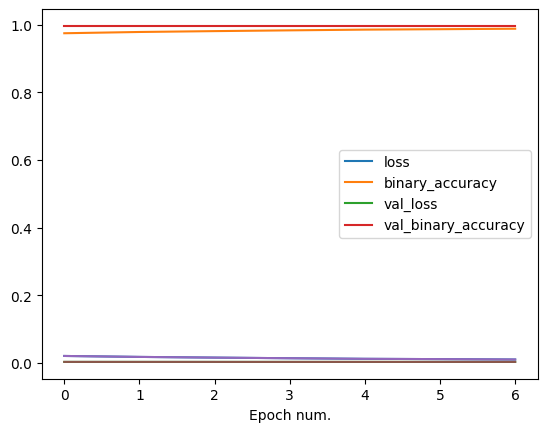

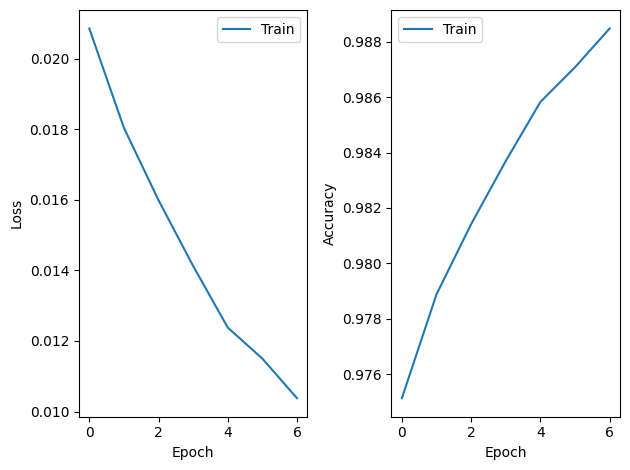

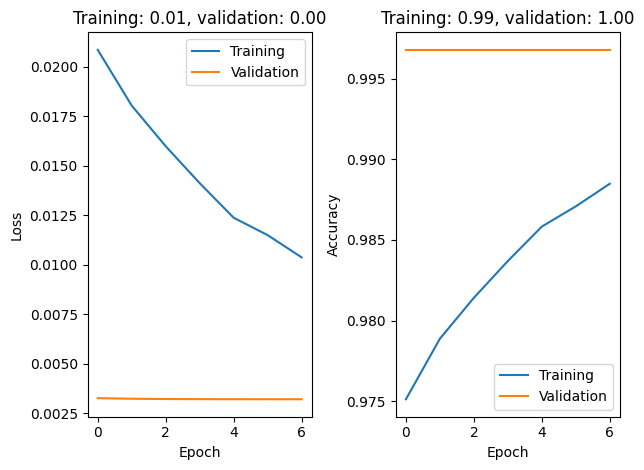

In [46]:
pd.DataFrame(rnn_history.history).plot()
plt.plot(rnn_history.history['loss'], label='Train loss')
plt.plot(rnn_history.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch num.')
plt.show()

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['binary_accuracy'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Training')
plt.plot(rnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training: {rnn_history.history["loss"][-1]:.2f}, validation: {rnn_history.history["val_loss"][-1]:.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['binary_accuracy'], label='Training')
plt.plot(rnn_history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training: {rnn_history.history["binary_accuracy"][-1]:.2f}, validation: {rnn_history.history["val_binary_accuracy"][-1]:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
rnn_loss, rnn_acc = modelRRRNN.evaluate(test_data, salidaEsperadaCompressedAjustadaTest)

2/2 [==============================] - 1s 93ms/step - loss: 0.0185 - binary_accuracy: 0.9967


In [52]:
modelRRRNN.save("rnn-Algigantix.h5") # guardar

In [53]:
modelRRRNNSaved = load_model("rnn-Algigantix.h5") # cargar

In [59]:
indicesDe5rnn = [diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"],diccionarioKeywords["EsteValorEstaMuyDesconocido"]]
print(indicesDe5rnn)

f_output_rnn = modelRRRNNSaved.predict(np.array([test_data[0]]))

for i in test_data[0]:
    if i != 0:
        print(index_word[i], end = " ")
print(type(f_output_rnn))
print(f_output_rnn)
abcr = f_output_rnn[0].tolist()

los5valoresmasAltosr = getMaxValues(abcr, 5)
print(los5valoresmasAltosr)

i = 0
k = 0
while i < len(los5valoresmasAltosr):
    aux = np.where(f_output_rnn == los5valoresmasAltosr[k])
    print(aux)
    print("ITERACION")
    k = k + 1
    j = 1
    while i < len(los5valoresmasAltosr) and j < len(aux) :
        print(aux[j][0])
        indicesDe5rnn[i] = aux[j][0]
        i = i +1
        j = j +1

# Y los pasamos a un formato que funcione
print(indicesDe5rnn)
for i in indicesDe5rnn:
    print(diccionarioKeywordsInvert[i])
    
print("ORIGINALES:")
indexao = 0
for i in salidaEsperadaCompressedAjustadaTest[0]:
    if i == 1:
        print(indexao)
        print(diccionarioKeywordsInvert[indexao])
    indexao += 1


[0, 0, 0, 0, 0]
1/1 [==============================] - 0s 46ms/step
scalable learning of entity and predicate embeddings for knowledge graph completion knowledge graphs kgs are a widely used formalism for representing knowledge in the web of data we focus on the problem of link prediction i e predicting missing links in large knowledge graphs so to discover new facts about the world representation learning models that embed entities and relation types in continuous vector spaces recently were used to achieve new state of the art link prediction results a limiting factor in these models is that the process of learning the optimal embedding vectors can be really time consuming and might even require days of computations for large kgs in this work we propose a principled method for sensibly reducing the learning time while converging to more accurate link prediction models furthermore we employ the proposed method for training and evaluating a set of novel and scalable models our extensiv

COMO VEMOS NOS SURGEN LOS MISMOS PROBLEMAS QUE ANTES, SOLO QUE EN ESTE CASO LOS VALORES EN VEZ DE APROXIMARSE TODOS AL 0, PARECEN AL MENOS ESTAR MÁS DISTRIBUIDOS Y APRENDE ALGO MEJOR

Probaremos ahora con otra red algo más grande, y utilizando el método de f1_scope

In [67]:
LOAD_PREVIOUS_RNN = False

checkpointsRNN = sorted(glob.glob('rnn-AlgigantixV2/*.h5'))
if LOAD_PREVIOUS_RNN and checkpointsRNN:
    print(f'Loading previous model: {checkpointsRNN[0]}')
    modelRRRNN = tf.keras.models.load_model(checkpointsRNN[0])
else:

    input_ = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(len(matrizSalidaSinKeywords), activation='sigmoid')(x)

    modelRRRNN = tf.keras.Model(input_, output)

modelRRRNN.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics= [tensorflow_addons.metrics.f_scores.F1Score(num_classes=len(matrizSalidaSinKeywords), threshold=0.5)]
)

modelRRRNN.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 333, 256)         253440    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 333, 256)         394240    
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 333, 256)          0         
                                                                 
 flatten_8 (Flatten)         (None, 85248)             0   

In [68]:
rnn_history = modelRRRNN.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs= 50,
    validation_split=0.1#,
    # Para ahorrar memoria, en esta no usamos callbacks, esperamos al final. Además nos permite hacer el entrenamiento más rápido
    #callbacks=[checkpointRecurrent, tb_callback]
)

Epoch 1/50
13/13 [==============================] - 26s 2s/step - loss: 0.2408 - f1_score: 0.0059 - val_loss: 0.2199 - val_f1_score: 0.0027
Epoch 2/50
13/13 [==============================] - 19s 1s/step - loss: 0.2154 - f1_score: 0.0054 - val_loss: 0.1842 - val_f1_score: 0.0017
Epoch 3/50
13/13 [==============================] - 20s 2s/step - loss: 0.1934 - f1_score: 0.0056 - val_loss: 0.1511 - val_f1_score: 0.0012
Epoch 4/50
13/13 [==============================] - 20s 2s/step - loss: 0.1743 - f1_score: 0.0061 - val_loss: 0.1223 - val_f1_score: 9.4741e-04
Epoch 5/50
13/13 [==============================] - 20s 2s/step - loss: 0.1569 - f1_score: 0.0059 - val_loss: 0.0971 - val_f1_score: 7.8217e-04
Epoch 6/50
13/13 [==============================] - 20s 2s/step - loss: 0.1401 - f1_score: 0.0063 - val_loss: 0.0751 - val_f1_score: 5.1609e-04
Epoch 7/50
13/13 [==============================] - 20s 2s/step - loss: 0.1242 - f1_score: 0.0055 - val_loss: 0.0564 - val_f1_score: 2.7017e-04
Epoc

In [69]:
modelRRRNN.save("rnn-AlgigantixV2.h5") # guardar

In [70]:
rnn_history = modelRRRNN.fit(
    data,
    salidaEsperadaCompressedAjustada,
    epochs= 100,
    validation_split=0.1#,
    # Para ahorrar memoria, en esta no usamos callbacks, esperamos al final. Además nos permite hacer el entrenamiento más rápido
    #callbacks=[checkpointRecurrent, tb_callback]
)

Epoch 1/100
13/13 [==============================] - 20s 2s/step - loss: 0.0054 - f1_score: 0.0020 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 20s 2s/step - loss: 0.0053 - f1_score: 0.0014 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 20s 2s/step - loss: 0.0053 - f1_score: 0.0014 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 20s 2s/step - loss: 0.0051 - f1_score: 0.0020 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 20s 2s/step - loss: 0.0051 - f1_score: 0.0031 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 6/100
13/13 [==============================] - 20s 2s/step - loss: 0.0050 - f1_score: 0.0021 - val_loss: 0.0032 - val_f1_score: 0.0000e+00
Epoch 7/100
13/13 [==============================] - 20s 2s/step - loss: 0.0049 - f1_score: 0.0018 - val_loss: 0.0032 - val_f1_sco

In [71]:
modelRRRNN.save("rnn-AlgigantixV2b.h5") # guardar


4555
Y ahora el cjto de validacion
455


Iniciando red de Convolución
La salida esperada tiene dimensiones 448 artículos, 1535 claves
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding (Embedding)       (None, 333, 200)          1351400   
                                                                 
 conv1d_18 (Conv1D)          (None, 332, 32)           12832     
                                                                 
 conv1d_19 (Conv1D)          (None, 330, 16)           1552      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 110, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (No